 <b>Self Case Study One -> Table of Contents</b>
* [Google Analytics Customer Revenue Prediction](#ga_header)
    * [Problem Statement](#problem_statement)
    * [Dataset](#dataset)
    * [Evaluation Metric](#metric)
    * [Exploratory Data Analysis](#eda)
        * [Finding Revenue Generating Customers](#revcustomers)
        * [Finding columns with single value](#singlecol)
        * [Exploring Device Information](#device)
        * [Exploring Geographical Information](#geo)
        * [Exploring Visitor Profile Information](#visitor)
        * [Handling Date](#date)
        * [Exploring trafficSource](#traffic)
        * [Processing test dataset](#test)
    * [Modeling](#modeling)
        * [Applying Linear Regression](#linearreg)
        * [Applying Ridge](#ridgReg)
        * [Applying XGBRegressor](#xgbReg)
        * [Applying LGBMRegressor](#lgbmReg)
        * [Applying RandomForestRegressor](#rfReg)
        * [Building Neural Network Architectures](#nn)
            * [MLP](#mlp_nn)
            * [LSTM](#lstm_nn)
            * [Conv1D](#conv_nn)
            * [More Features](#feats)
    * [Analysis of various model implementations](#analyze)
        * [Data Loading and Preprocessing](#preprocess)
        * [Modeling Analyis](#model_analysis)
        * [Conclusion](#conclude)
    * [Best Score](#best)

<h1>Google Analytics Customer Revenue Prediction</h1><a class="anchor" id="ga_header"></a>
<i>Predict how much GStore customers will spend</i><br>
<a href='https://www.kaggle.com/c/ga-customer-revenue-prediction/overview'>https://www.kaggle.com/c/ga-customer-revenue-prediction/overview</a>

<h2> Problem Statement </h2><a class="anchor" id="problem_statement"></a>
<p>The 80/20 rule has proven true for many businesses–only a small percentage of customers produce most of the revenue. As such, marketing teams are challenged to make appropriate investments in promotional strategies.</p>
<p>This case study is about predicting futuristic transaction revenue per customer for the products
sold in Google Store. This case study is based on 80/20 rule also known as Pareto Principle,
which is quite true for diverse domains. (Pareto principle states that for many events, roughly
80% of the effects come from 20% of the causes).
On similar lines of 80/20 rule, this case study aims to find those 20% customers who account
for 80% of the revenue, in order to fine tune usage of marketing budgets for better targeting the
revenue generating customers.</p>

<h2>Dataset</h2><a class="anchor" id="dataset"></a>

<ul><li><b>train_v2.csv ( 23.67GB )</b> - Contains user transaction data for the period Aug 1 st
2016 to April 30 th 2018 (638 days)</li>
    <li><b>test_v2.csv ( 7.09GB )</b>– Contains user transaction data for the period May 1 st 2018
to Oct 15 th 2018 (168 days)</li>
<li><i>We have to predict log of transaction revenue of each customer for the future
    period Dec 1 st 2018 to Jan 31 st 2019(62 days)</i></li>

<ul>
    <li><b>fullVisitorId</b>- A unique identifier for each user of the Google Merchandise Store.
    <li><b>channelGrouping </b>- The channel via which the user came to the Store.
    <li><b>date</b> - The date on which the user visited the Store.
    <li><b>device</b> - The specifications for the device used to access the Store.
    <li><b>geoNetwork</b> - This section contains information about the geography of the user.
    <li><b>socialEngagementType</b> - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
    <li><b>totals </b>- This section contains aggregate values across the session like pagviews, hits.
    <li><b>trafficSource </b>- This section contains information about the Traffic Source from which the session originated.
    <li><b>visitId</b> - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
    <li><b>visitNumber</b> - The session number for this user. If this is the first session, then this is set to 1.
    <li><b>visitStartTime </b>- The timestamp (expressed as POSIX time).
    <li><b>hits </b>- This row and nested fields are populated for any and all types of hits. Provides a record of all page visits.
    <li><b>customDimensions </b>- This section contains any user-level or session-level custom dimensions that are set for a session. This is a repeated field and has an entry for each dimension that is set.
</ul>

<h2>Evaluation Metric</h2><a class="anchor" id="metric"></a>
<img src='https://i.imgur.com/Hk09Ydv.png' width=35% />

<p>where y hat is the natural log of the predicted revenue for a customer and y is the natural log of the actual summed revenue value plus one.</p>

<h2>Exploratory Data Analysis</h2> <a class="anchor" id="eda"></a>

<p>As the dataset size is beyond the capacity of RAM of a standard PC, We are making use of <a href='https://dask.org/'>dask</a> for processing the data.</p>

In [1]:
# Data processing
import pandas as pd
import json
import os
import numpy as np
from pandas.io.json import json_normalize
pd.options.display.max_columns=100
%matplotlib inline
import datetime
import time
from prettytable import PrettyTable

# Distributed Data processing using Dask
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster
from joblib import parallel_backend

# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor

#Hyperparameter Search
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

#Neural Networks
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Dropout
from sklearn.preprocessing import Normalizer
from keras import regularizers
from keras.layers import LSTM, Conv1D, Flatten
from keras.callbacks import ModelCheckpoint ,ReduceLROnPlateau, EarlyStopping, TensorBoard

#metrics
from sklearn.metrics import mean_squared_error as mse

In [2]:
#https://www.kaggle.com/sudalairajkumar/simple-exploration-baseline-ga-customer-revenue
def load_df(csv_path='train_v2.csv', nrows=None):
    """
    Function to load the dataset and format json columns
    """
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = dd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df

In [3]:
cust_df = load_df()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


In [145]:
cust_df.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'visitId', 'visitNumber',
       'visitStartTime', 'device.browser', 'device.operatingSystem',
       'device.isMobile', 'device.deviceCategory', 'geoNetwork.continent',
       'geoNetwork.subContinent', 'geoNetwork.country', 'geoNetwork.region',
       'geoNetwork.metro', 'geoNetwork.city', 'geoNetwork.networkDomain',
       'totals.hits', 'totals.pageviews', 'totals.bounces', 'totals.newVisits',
       'totals.sessionQualityDim', 'totals.timeOnSite', 'totals.transactions',
       'totals.transactionRevenue', 'trafficSource.campaign',
       'trafficSource.source', 'trafficSource.medium', 'trafficSource.keyword',
       'trafficSource.referralPath', 'trafficSource.isTrueDirect',
       'trafficSource.adContent', 'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.

In [5]:
cust_df.head(3)

,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.sessionQualityDim,totals.timeOnSite,totals.transactions,totals.transactionRevenue,totals.totalTransactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.referralPath,trafficSource.isTrueDirect,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.campaignCode
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508198450,1,1508198450,Firefox,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Western Europe,Germany,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,1,NaN,NaN,NaN,NaN,(not set),google,organic,water bottle,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,1508176307,6,1508176307,Chrome,not available in demo dataset,not available in demo dataset,Chrome OS,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Cupertino,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,1,2,2,NaN,NaN,2,28,NaN,NaN,NaN,(not set),sites.google.com,referral,NaN,not available in demo dataset,/a/google.com/transportation/mtv-services/bike...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,7992466427990357681,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508201613,1,1508201613,Chrome,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,windj

In [6]:
#dropping redundant columns
cust_df = cust_df.drop(['hits','customDimensions','totals.totalTransactionRevenue'],axis=1).compute()

In [7]:
print("Train Data Set:",cust_df.shape)
cust_df.head()

Train Data Set: (1708337, 57)


,channelGrouping,date,fullVisitorId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.sessionQualityDim,totals.timeOnSite,totals.transactions,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.referralPath,trafficSource.isTrueDirect,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.campaignCode
0,Organic Search,20171016,3162355547410993243,Not Socially Engaged,1508198450,1,1508198450,Firefox,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Western Europe,Germany,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,1,NaN,NaN,NaN,(not set),google,organic,water bottle,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Referral,20171016,8934116514970143966,Not Socially Engaged,1508176307,6,1508176307,Chrome,not available in demo dataset,not available in demo dataset,Chrome OS,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Cupertino,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,1,2,2,NaN,NaN,2,28,NaN,NaN,(not set),sites.google.com,referral,NaN,not available in demo dataset,/a/google.com/transportation/mtv-services/bike...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Direct,20171016,7992466427990357681,Not Socially Engaged,1508201613,1,1508201613,Chrome,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,windjammercable.net,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,2,2,NaN,1,1,38,NaN,NaN,(not set),(direct),(none),NaN,not available in demo dataset,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20171016,9075655783635761930,Not Socially Engaged,1508169851,1,1508169851,Chrome,not available in d

In [8]:
#view the dataframe information ..
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1708337 entries, 0 to 337
Data columns (total 57 columns):
 #   Column                                             Dtype 
---  ------                                             ----- 
 0   channelGrouping                                    object
 1   date                                               int64 
 2   fullVisitorId                                      object
 3   socialEngagementType                               object
 4   visitId                                            int64 
 5   visitNumber                                        int64 
 6   visitStartTime                                     int64 
 7   device.browser                                     object
 8   device.browserVersion                              object
 9   device.browserSize                                 object
 10  device.operatingSystem                             object
 11  device.operatingSystemVersion                      object
 12  devi

### Finding Revenue Generating Customers  <a class="anchor" id="revcustomers"></a>

In [9]:
cust_df['totals.transactionRevenue'] = cust_df['totals.transactionRevenue'].astype('float')
unique_cust = cust_df.groupby('fullVisitorId')['totals.transactionRevenue'].sum().reset_index()

In [10]:
uniq_customers = unique_cust.shape[0]
print("Number of Unique Customers in train:",uniq_customers)

Number of Unique Customers in train: 1323730


In [11]:
non_zero_rev = (unique_cust['totals.transactionRevenue']>0).sum()
print("Customers with non-zero revenue in train:",non_zero_rev)

Customers with non-zero revenue in train: 14403


In [12]:
ratio_of_revenue_gen_cust = np.round(non_zero_rev*100/uniq_customers,3)
print("Percentage of revenue generating customers in train :: {}%".format(ratio_of_revenue_gen_cust))

Percentage of revenue generating customers in train :: 1.088%


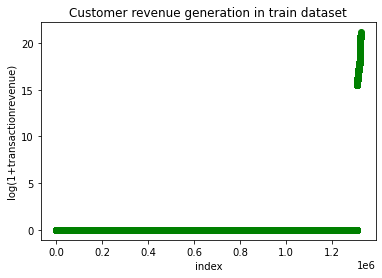

In [13]:
%matplotlib inline
plt.scatter(range(uniq_customers),np.sort(np.log1p(unique_cust['totals.transactionRevenue'].values)),c='green')
plt.title('Customer revenue generation in train dataset')
plt.ylabel('log(1+transactionrevenue)')
plt.xlabel('index')
plt.show()

<b>Summary</b><br>
 This plot clearly shows that only few customers are generating most of the revenue. 
 Hence proving 80/20 rule


### Finding columns with single value<a class="anchor" id="singlecol"></a>

In [14]:
#dropna = False: which means we are not ignoring values with nan
single_valued_cols = [col for col in cust_df.columns if cust_df[col].nunique(dropna=False) == 1]
print("Single Valued Columns:\n",single_valued_cols)

Single Valued Columns:
 ['socialEngagementType', 'device.browserVersion', 'device.browserSize', 'device.operatingSystemVersion', 'device.mobileDeviceBranding', 'device.mobileDeviceModel', 'device.mobileInputSelector', 'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName', 'device.flashVersion', 'device.language', 'device.screenColors', 'device.screenResolution', 'geoNetwork.cityId', 'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits', 'trafficSource.adwordsClickInfo.criteriaParameters', 'trafficSource.campaignCode']


=========================================================================================<br>
The above columns does not help in revenue prediction, so we remove those columns

### Exploring Device Information<a class="anchor" id="device"></a>

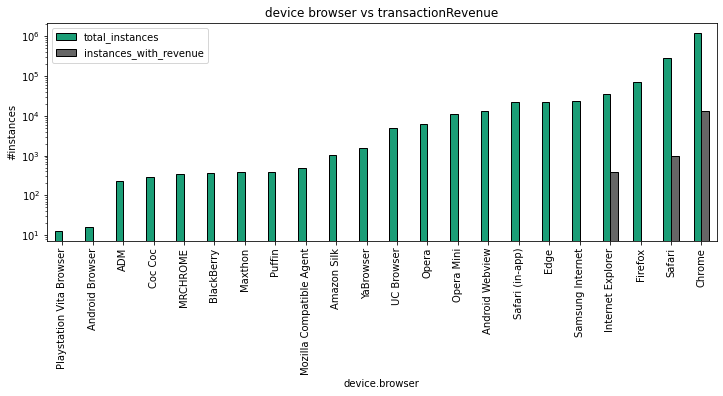

In [15]:
# Attributes :: browser, operatingSystem, isMobile, deviceCategory
#dataframe.count - counts non NA cells

#1. device.browser
agg_df = cust_df.groupby('device.browser')['totals.transactionRevenue'].agg(['size','count'])
agg_df.columns = ['total_instances','instances_with_revenue']

sorted_agg_df = agg_df.sort_values(by=['total_instances','device.browser'])
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html#pandas.DataFrame.plot
sorted_agg_df.plot(kind='bar',figsize=(12,4),title='device browser vs transactionRevenue',logy=True,cmap='Dark2',edgecolor='black')
plt.ylabel('#instances')
plt.show()

<b>Summary</b>
<ul>
<li>Majority of customer visits are through chrome browser followed by Safari, Firefox and Internet Explorer  </li>
<li>Revenue is genereated from the customers who used Chrome, Safari and Internet Explorer</li>
</ul>

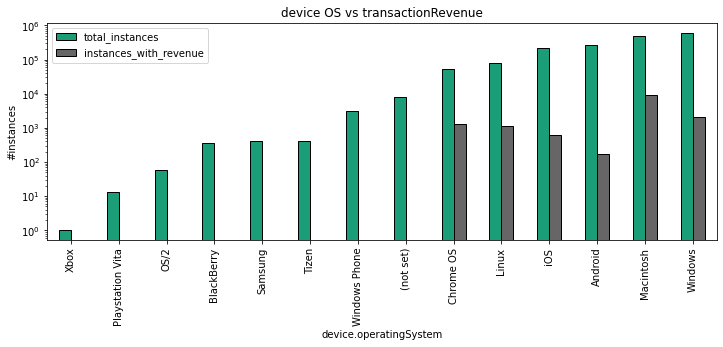

In [16]:
#2. device.operatingSystem
agg_df = cust_df.groupby('device.operatingSystem')['totals.transactionRevenue'].agg(['size','count'])
agg_df.columns = ['total_instances','instances_with_revenue']

sorted_agg_df = agg_df.sort_values(by=['total_instances','device.operatingSystem'])
sorted_agg_df.plot(kind='bar',figsize=(12,4),title='device OS vs transactionRevenue',logy=True,cmap='Dark2',edgecolor='black')
plt.ylabel('#instances')
plt.show()

<b>Summary</b>
<ul>
<li>Top operating systems include Mac, Windows, Android, iOS, Linux and Chrome OS, inaddition to contributing to majority of customer visits , most of the revenue generating customers are using the above operating systems </li>
 <li>In mobile OS category, IOS users are contributing to more revenue when compared to Andriod users</li>
</ul>

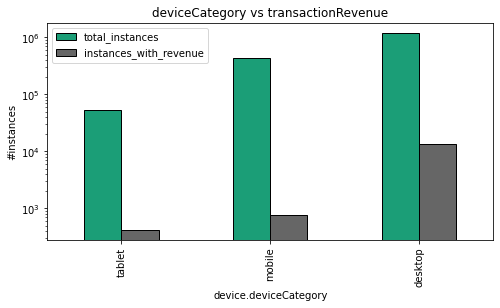

In [17]:
#3. device.deviceCategory
agg_df = cust_df.groupby('device.deviceCategory')['totals.transactionRevenue'].agg(['size','count'])
agg_df.columns = ['total_instances','instances_with_revenue']

sorted_agg_df = agg_df.sort_values(by=['total_instances','device.deviceCategory'])
sorted_agg_df.plot(kind='bar',figsize=(8,4),title='deviceCategory vs transactionRevenue',logy=True,colormap='Dark2',edgecolor='black')
plt.ylabel('#instances')
plt.show()

<b>Summary</b>
<ul>
<li>Majority of the revenue generating customers use desktop, followed by mobile and tablet</li>
<li>Customers using mobiles are contributing to more visits and revenue when compared to that of customers using tablets</li>
</ul>

### Exploring Geographical Information<a class="anchor" id="geo"></a>

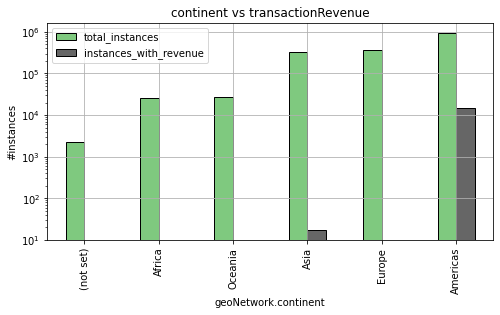

In [18]:
# continent, subContinent, country, region, metro, city, networkDomain

# geoNetwork.continent
agg_df = cust_df.groupby('geoNetwork.continent')['totals.transactionRevenue'].agg(['size','count'])
agg_df.columns = ['total_instances','instances_with_revenue']

sorted_agg_df = agg_df.sort_values(by=['total_instances','geoNetwork.continent'])
#https://matplotlib.org/examples/color/colormaps_reference.html
sorted_agg_df.plot(kind='bar',figsize=(8,4),title='continent vs transactionRevenue',logy=True,grid=True,colormap='Accent',edgecolor='black')
plt.ylabel('#instances')
plt.show()

<b>Summary</b>
<ul>
<li>Customers from Americas contribute to more number of visits as well as revenues when compared to customers from other continents</li>
<li>Asian customers are contributing to a small chunk of revenues after customers from Americas</li>
<li>Customers from other continents are visiting but not contributing to any revenue</li>
</ul>

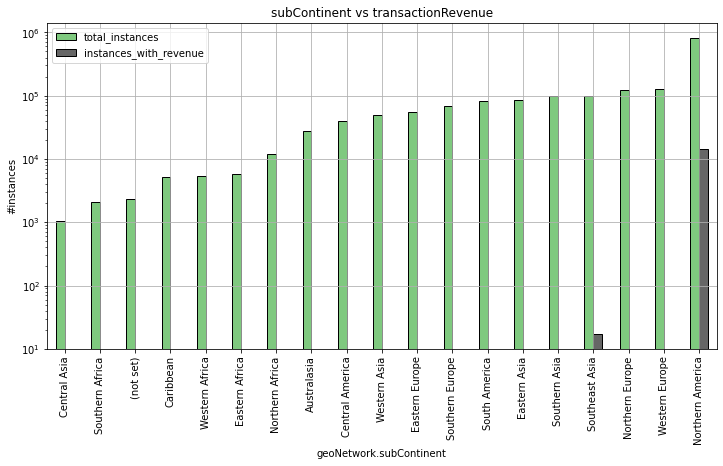

In [19]:
#geoNetwork.subContinent
agg_df = cust_df.groupby('geoNetwork.subContinent')['totals.transactionRevenue'].agg(['size','count'])
agg_df.columns = ['total_instances','instances_with_revenue']

sorted_agg_df = agg_df.sort_values(by=['total_instances','geoNetwork.subContinent'])
sorted_agg_df.plot(kind='bar',figsize=(12,6),title='subContinent vs transactionRevenue',logy=True,grid=True,colormap='Accent',edgecolor='black')
plt.ylabel('#instances')
plt.show()

<b>Summary</b>
<ul>
<li>Customers from North America contribute to more number of visits as well as revenues when compared to customers from other subcontinents</li>
<li>South East Asian customers are contributing to a small chunk of revenues.</li>
</ul>

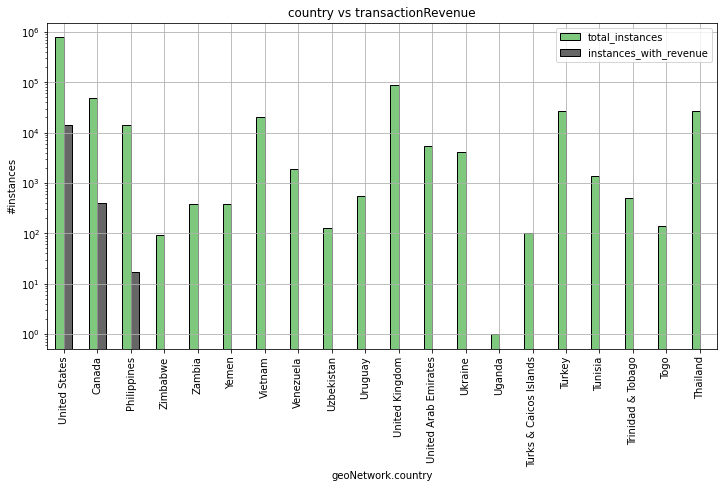

In [20]:
#geoNetwork.country
agg_df = cust_df.groupby('geoNetwork.country')['totals.transactionRevenue'].agg(['size','count'])
agg_df.columns = ['total_instances','instances_with_revenue']

sorted_agg_df = agg_df.sort_values(by=['instances_with_revenue','geoNetwork.country'],ascending=False)
#taking only top 20 countries 
sorted_agg_df.head(20).plot(kind='bar',figsize=(12,6),title='country vs transactionRevenue',logy=True,grid=True,cmap='Accent',edgecolor='black')
plt.ylabel('#instances')
plt.show()

<b>Summary</b>
<ul>
<li>Only customers from US, Canada and Philippines are contributing to significant revenue</li>
</ul>

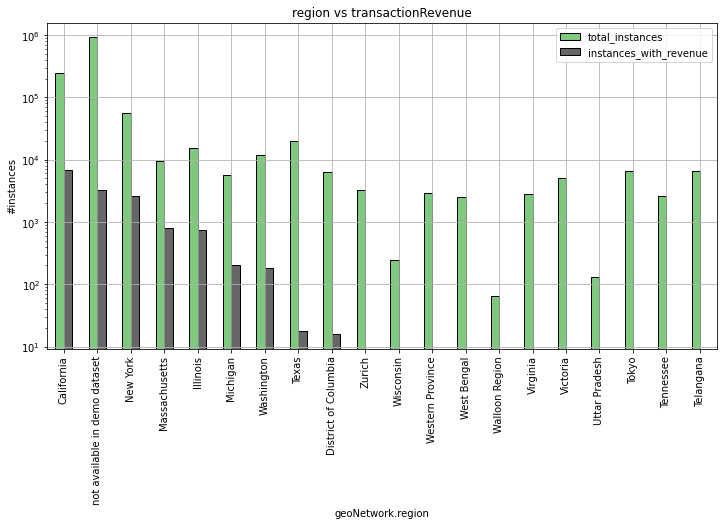

In [21]:
#geoNetwork.region
agg_df = cust_df.groupby('geoNetwork.region')['totals.transactionRevenue'].agg(['size','count'])
agg_df.columns = ['total_instances','instances_with_revenue']

sorted_agg_df = agg_df.sort_values(by=['instances_with_revenue','geoNetwork.region'],ascending=False)
sorted_agg_df.head(20).plot(kind='bar',figsize=(12,6),title='region vs transactionRevenue',logy=True,grid=True,colormap='Accent',edgecolor='black')
plt.ylabel('#instances')
plt.show()

<b>Summary</b>
<ul>
<li>Cutomers from most of the American regions contribute majority of revenue</li>
<li>Unlabeled region is observed which is contributing to major chunk of revenue</li>
 <li>Few Indain regions like West Bengal, Uttar Pradesh and Telangana are observed with more number of visits but have not generated any revenue</li>
</ul>

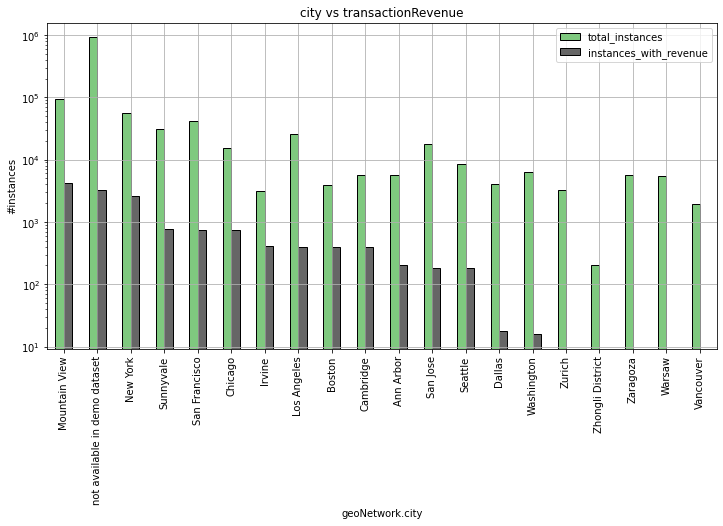

In [22]:
#geoNetwork.city
agg_df = cust_df.groupby('geoNetwork.city')['totals.transactionRevenue'].agg(['size','count'])
agg_df.columns = ['total_instances','instances_with_revenue']

sorted_agg_df = agg_df.sort_values(by=['instances_with_revenue','geoNetwork.city'],ascending=False)
sorted_agg_df.head(20).plot(kind='bar',figsize=(12,6),title='city vs transactionRevenue',logy=True,grid=True,colormap='Accent',edgecolor='black')
plt.ylabel('#instances')
plt.show()

<b>Summary</b>
<ul>
<li>Cutomers from most of the American cities contribute majority of revnue</li>
<li>Unlabeled city is observed which is contributing to major chunk of revenue</li>
</ul>

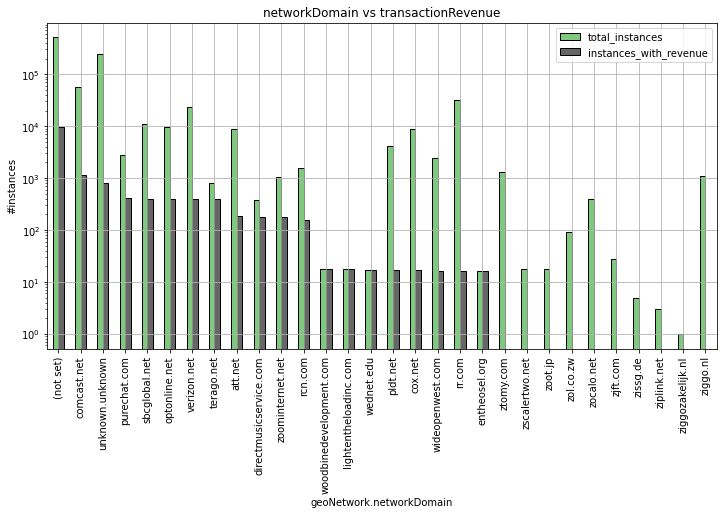

In [23]:
#geoNetwork.networkDomain
agg_df = cust_df.groupby('geoNetwork.networkDomain')['totals.transactionRevenue'].agg(['size','count'])
agg_df.columns = ['total_instances','instances_with_revenue']

sorted_agg_df = agg_df.sort_values(by=['instances_with_revenue','geoNetwork.networkDomain'],ascending=False)
sorted_agg_df.head(30).plot(kind='bar',figsize=(12,6),title='networkDomain vs transactionRevenue',logy=True,grid=True,colormap='Accent',edgecolor='black')
plt.ylabel('#instances')
plt.show()

<b>Summary</b>
<ul>
<li>Customers with (not set) network domain contribute to majority of revnue as well as visits</li>
<li>Customers from comcast.net contribute to second most chunk of revenue</li>
</ul>

### Exploring Visitor Profile Information <a class="anchor" id="visitor"></a>

In [24]:
#totals -> hits, pageviews, bounces, newVisits, sessionQualityDim, timeOnSite, transactions
#visitNumber,visitStartTime
totalsjson =  ['totals.hits','totals.pageviews','totals.bounces','totals.newVisits','totals.sessionQualityDim','totals.timeOnSite','totals.transactions']
print("colname :: #unique_values")
for col in totalsjson:
    cust_df[col] = cust_df[col].astype(float)
    print(col,"::",cust_df[col].nunique(dropna=False))

colname :: #unique_values
totals.hits :: 85
totals.pageviews :: 68
totals.bounces :: 2
totals.newVisits :: 2
totals.sessionQualityDim :: 89
totals.timeOnSite :: 908
totals.transactions :: 3


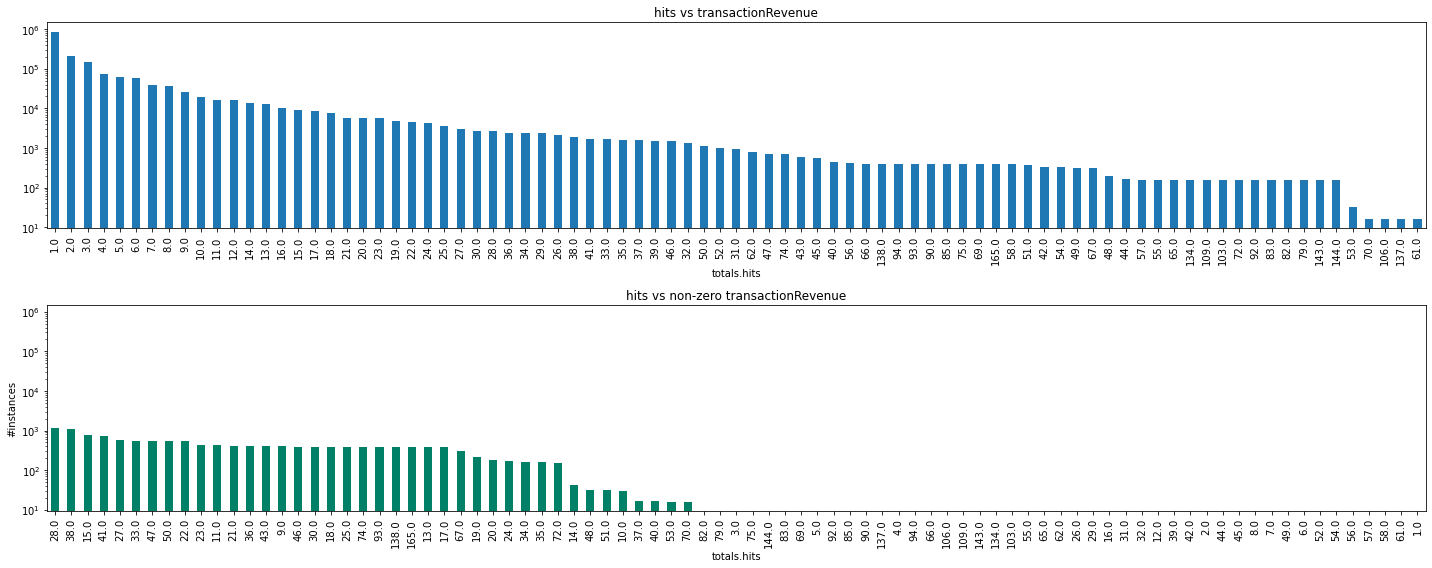

In [25]:
#totals.hits
agg_df = cust_df.groupby('totals.hits')['totals.transactionRevenue'].agg(['size','count'])
agg_df.columns = ['total_instances','instances_with_revenue']


fig,axes = plt.subplots(2,1,sharey=True)
sorted_agg_df = agg_df.sort_values(by=['total_instances'],ascending=False)
sorted_agg_df['total_instances'].plot(kind='bar',figsize=(20,8),logy=True,ax=axes[0],title='hits vs transactionRevenue')

#https://stackoverflow.com/questions/22483588/how-can-i-plot-separate-pandas-dataframes-as-subplots
sorted_agg_df = agg_df.sort_values(by=['instances_with_revenue'],ascending=False)
sorted_agg_df['instances_with_revenue'].plot(kind='bar',figsize=(20,8),logy=True,colormap='summer',ax=axes[1],title="hits vs non-zero transactionRevenue")
plt.ylabel('#instances')
plt.tight_layout() #gives enough space between plots
plt.show()


<b>Summary</b>
<ul>
<li>Visit instances are more with small number of hits and gradually decreasing as the hit count is increasing</li>
<li>Major chunk of transactionRevenue is generated when hits count is between 10 and 70 approximately</li>
</ul>

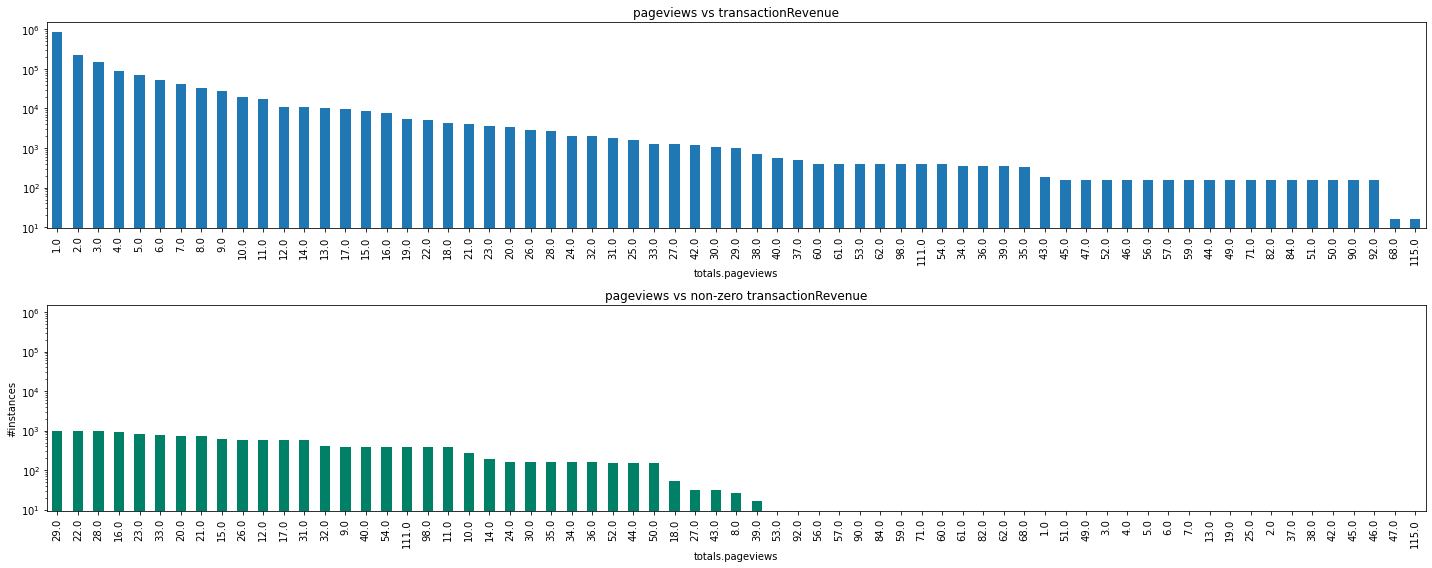

In [26]:
#totals.pageviews
agg_df = cust_df.groupby('totals.pageviews')['totals.transactionRevenue'].agg(['size','count'])
agg_df.columns = ['total_instances','instances_with_revenue']


fig,axes = plt.subplots(2,1,sharey=True)
sorted_agg_df = agg_df.sort_values(by=['total_instances'],ascending=False)
sorted_agg_df['total_instances'].plot(kind='bar',figsize=(20,8),logy=True,ax=axes[0],title='pageviews vs transactionRevenue')

#https://stackoverflow.com/questions/22483588/how-can-i-plot-separate-pandas-dataframes-as-subplots
sorted_agg_df = agg_df.sort_values(by=['instances_with_revenue'],ascending=False)
sorted_agg_df['instances_with_revenue'].plot(kind='bar',figsize=(20,8),logy=True,colormap='summer',ax=axes[1],title="pageviews vs non-zero transactionRevenue")
plt.ylabel('#instances')
plt.tight_layout() #gives enough space between plots
plt.show()


<b>Summary</b>
<ul>
<li>Visit instances are more with small number of pageviews and gradually decreasing as the pageview count is increasing</li>
<li>Major chunk of transactionRevenue is generated when pageview count is between 10 and 50 approximately</li>
</ul>

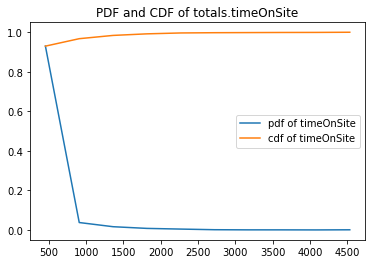

In [27]:
#PDF code snippet , referred from classroom notes
cust_df['totals.timeOnSite'].fillna(cust_df['totals.timeOnSite'].mean(),inplace=True) #filled nan with mean timespent
counts,bin_edges = np.histogram(cust_df['totals.timeOnSite'],bins=10,density=True)
pdf = counts/(sum(counts))
cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:],pdf,label='pdf of timeOnSite')
plt.plot(bin_edges[1:],cdf,label='cdf of timeOnSite')
plt.title("PDF and CDF of totals.timeOnSite")
plt.legend()
plt.show()

<b>Summary</b>
<ul>
<li>More than 90% of the customers spent time below 1000 secs</li>
<li>Less than 10% of customers spent time between 1000 and 4500 secs</li>
</ul>

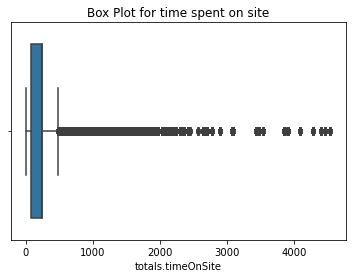

In [28]:
sns.boxplot(cust_df['totals.timeOnSite'])
plt.title("Box Plot for time spent on site")
plt.show()

<b>Summary</b>
<ul>
<li>Approximate time spent on site is below 100 sec</li>
<li>Many outliers are present.(values>200sec)</li>
</ul>

### Handling date feature<a class="anchor" id="date"></a>

In [29]:
cust_df['date'] = cust_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:]))) #year,month,day

In [30]:
cust_df['date'].head(3)

0    2017-10-16
1    2017-10-16
2    2017-10-16
Name: date, dtype: object

In [31]:
#date
agg_df = cust_df.groupby('date')['totals.transactionRevenue'].agg(['size','count'])
agg_df.columns = ['total_instances','instances_with_revenue']
sorted_agg_df = agg_df.sort_index()

In [32]:
sorted_agg_df.tail(3)

,total_instances,instances_with_revenue
date,,
2018-04-28,1972,27
2018-04-29,1977,27
2018-04-30,2753,24


In [33]:
sorted_agg_df.head(3)

,total_instances,instances_with_revenue
date,,
2016-08-01,1711,24
2016-08-02,2140,24
2016-08-03,2890,24


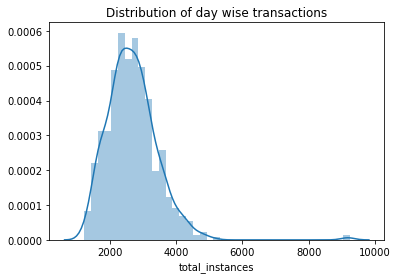

In [34]:
sns.distplot(sorted_agg_df.total_instances)
plt.title('Distribution of day wise transactions')
plt.show()

<b>Summary</b>
<ul>
<li>0.05% of the days, transactions have count between 2500 and 3500</li>
<li>The distributions looks right skewed</li>
</ul>

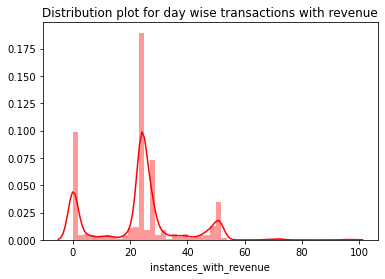

In [35]:
sns.distplot(sorted_agg_df.instances_with_revenue,color='r')
plt.title('Distribution plot for day wise transactions with revenue')
plt.show()

<b>Summary</b>
<ul>
<li>There is no clear distribution of revenue generating transactions count</li>
<li>7.5% of the days , the number of revenue generating transactions lies between 25 and and 35</li>
</ul>

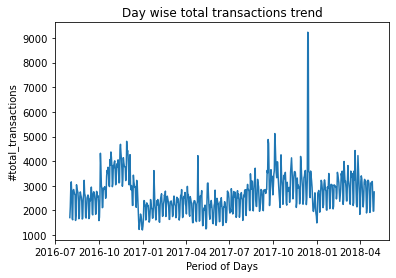

In [36]:
#https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.plot.html
plt.plot(sorted_agg_df.total_instances,scalex=True)
plt.title('Day wise total transactions trend')
plt.xlabel('Period of Days')
plt.ylabel('#total_transactions')
plt.show()

<b>Summary</b>
<ul>
<li>We can clearly observe that total transaction count tends to increase till year end</li>
<li>Transactions count is very high especially towards the end of the year</li>
</ul>

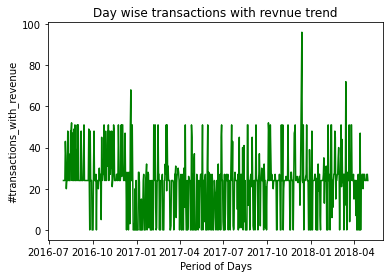

In [37]:
plt.plot(sorted_agg_df.instances_with_revenue,scalex=True,color='g')
plt.title('Day wise transactions with revnue trend')
plt.xlabel('Period of Days')
plt.ylabel('#transactions_with_revenue')
plt.show()

<b>Summary</b>
<ul>
<li>In the intial period, revenue generating transaction count is high during July-2017 to Sep-2017. and it fell during Oct-2017 and then started increasing again till Dec-2016.</li>
<li>Revenue generating transactions count is high especially towards the end of the year and very low in the first half of the year-2018</li>
</ul>

### Exploring trafficeSource<a class="anchor" id="traffic"></a>

In [38]:
traf_src_cols = ['trafficSource.campaign','trafficSource.source','trafficSource.medium','trafficSource.keyword','trafficSource.referralPath','trafficSource.isTrueDirect','trafficSource.adContent','trafficSource.adwordsClickInfo.page','trafficSource.adwordsClickInfo.slot','trafficSource.adwordsClickInfo.gclId','trafficSource.adwordsClickInfo.adNetworkType','trafficSource.adwordsClickInfo.isVideoAd']
print("feature :: #unique_values")
print("-"*30)
for col in traf_src_cols:
    print(col," :: ",cust_df[col].nunique(dropna=False))

feature :: #unique_values
------------------------------
trafficSource.campaign  ::  11
trafficSource.source  ::  52
trafficSource.medium  ::  6
trafficSource.keyword  ::  59
trafficSource.referralPath  ::  244
trafficSource.isTrueDirect  ::  2
trafficSource.adContent  ::  15
trafficSource.adwordsClickInfo.page  ::  4
trafficSource.adwordsClickInfo.slot  ::  3
trafficSource.adwordsClickInfo.gclId  ::  359
trafficSource.adwordsClickInfo.adNetworkType  ::  3
trafficSource.adwordsClickInfo.isVideoAd  ::  2


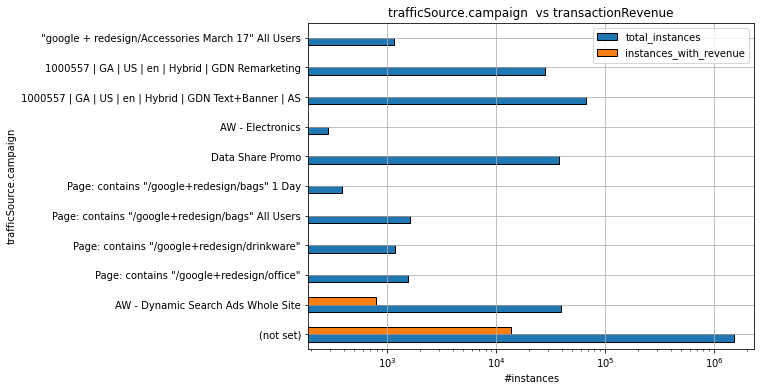

In [39]:
#trafficSource.campaign 
agg_df = cust_df.groupby('trafficSource.campaign')['totals.transactionRevenue'].agg(['size','count'])
agg_df.columns = ['total_instances','instances_with_revenue']

sorted_agg_df = agg_df.sort_values(by=['instances_with_revenue','trafficSource.campaign'],ascending=False)
sorted_agg_df.plot(kind='barh',figsize=(8,6),title='trafficSource.campaign  vs transactionRevenue',logx=True,grid=True,edgecolor='black')
plt.xlabel('#instances')
plt.show()

<b>Summary</b>
<ul>
<li>campaign field is (not set) for majority revenue generating transactions</li>
<li>Most of the visits from other categories did not yeild non-zero revenues</li>
</ul>

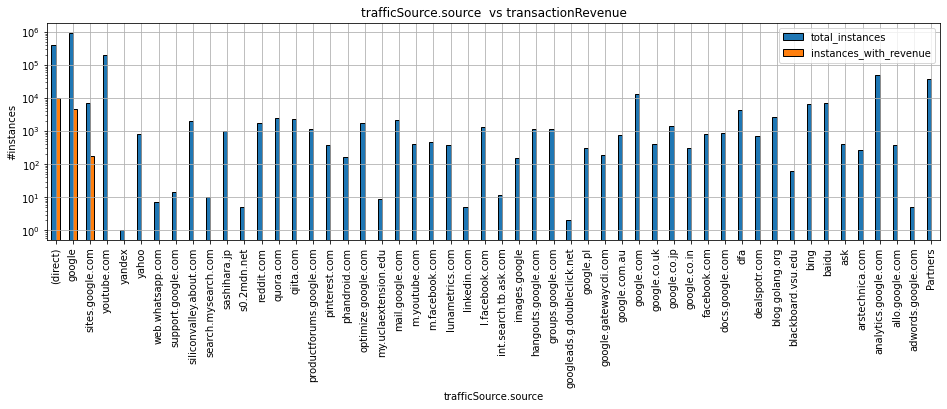

In [40]:
#trafficSource.source 
agg_df = cust_df.groupby('trafficSource.source')['totals.transactionRevenue'].agg(['size','count'])
agg_df.columns = ['total_instances','instances_with_revenue']

sorted_agg_df = agg_df.sort_values(by=['instances_with_revenue','trafficSource.source'],ascending=False)
sorted_agg_df.plot(kind='bar',figsize=(16,4),title='trafficSource.source  vs transactionRevenue',logy=True,grid=True,edgecolor='black')
plt.ylabel('#instances')
plt.show()

<b>Summary</b>
<ul>
    <li>A major chunk of revenues came from the customers who directly visited the Gstore, followed by traffic from google and sites.google.com</li>
    <li>Other sources didnt yeild any non-zero revenue</li>
</ul>

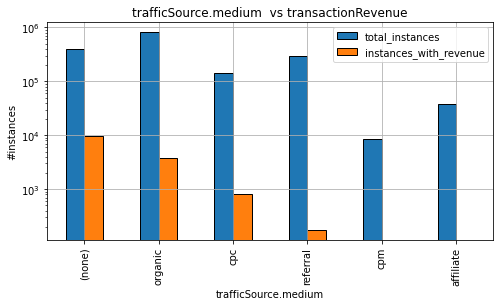

In [41]:
#trafficSource.medium 
agg_df = cust_df.groupby('trafficSource.medium')['totals.transactionRevenue'].agg(['size','count'])
agg_df.columns = ['total_instances','instances_with_revenue']

sorted_agg_df = agg_df.sort_values(by=['instances_with_revenue','trafficSource.medium'],ascending=False)
sorted_agg_df.plot(kind='bar',figsize=(8,4),title='trafficSource.medium  vs transactionRevenue',logy=True,grid=True,edgecolor='black')
plt.ylabel('#instances')
plt.show()

<b>Summary</b>
<ul>
<li>More visits observed in organic medium followed by (none) category, cpc category and referral category </li>
<li>More revenue is generated from (none) category medium, followed by organic and cpc mediums</li>
    <li>Significant visits have come through affliate and cpm categories but no revenue is generated from them</li>
</ul>

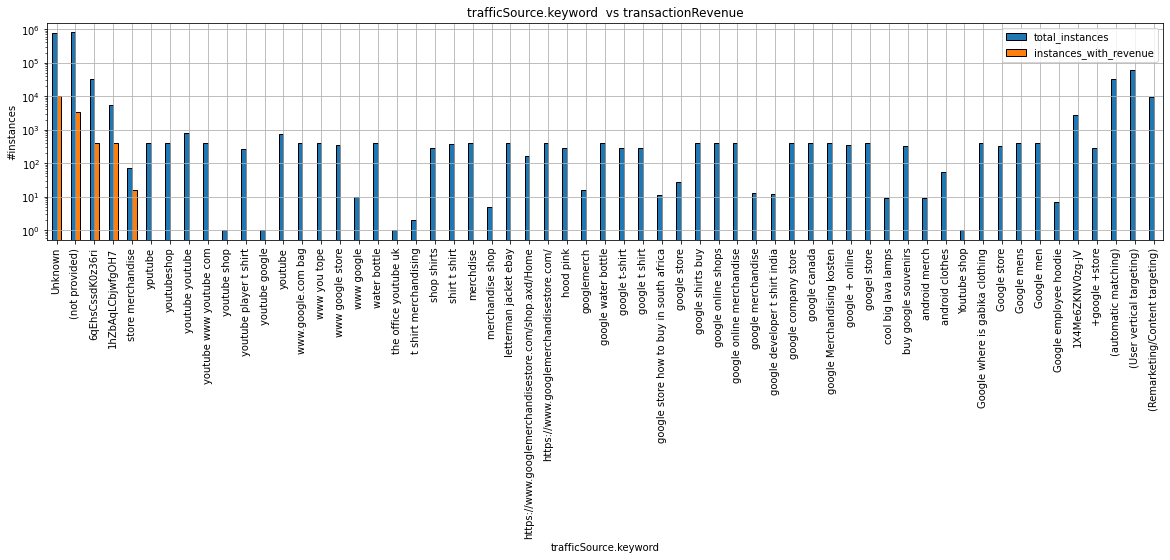

In [42]:
#trafficSource.keyword 
cust_df['trafficSource.keyword'].fillna('Unknown',inplace=True)
agg_df = cust_df.groupby('trafficSource.keyword')['totals.transactionRevenue'].agg(['size','count'])
agg_df.columns = ['total_instances','instances_with_revenue']

sorted_agg_df = agg_df.sort_values(by=['instances_with_revenue','trafficSource.keyword'],ascending=False)
sorted_agg_df.plot(kind='bar',figsize=(20,4),title='trafficSource.keyword  vs transactionRevenue',logy=True,grid=True,edgecolor='black')
plt.ylabel('#instances')
plt.show()

<b>Summary</b>
<ul>
<li>Top most revenue generating keywords are marked as (Unknown) and (not provided)</li>
<li>One known keyword is 'store merchandise' which helped in generating revenue</li>
 <li>Some notable keywords like (automatice matching),(User vertical targeting),(Remarketing/content targeting) resulted in more number of visits when compared to others but didnt yeild any revenue</li>
</ul>

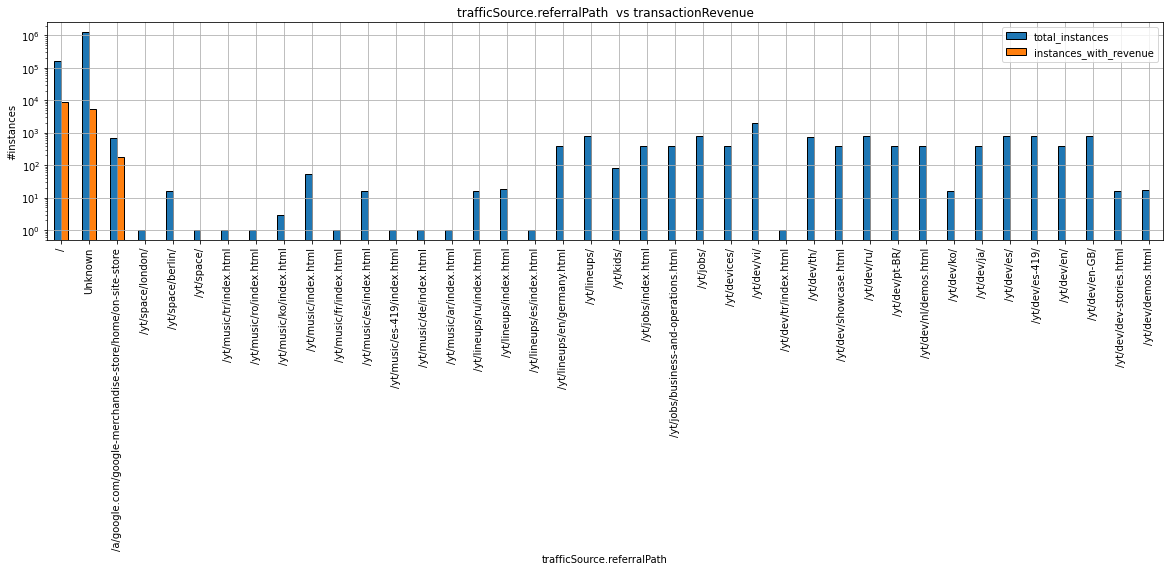

In [43]:
#trafficSource.referralPath 
cust_df['trafficSource.referralPath'].fillna('Unknown',inplace=True)
agg_df = cust_df.groupby('trafficSource.referralPath')['totals.transactionRevenue'].agg(['size','count'])
agg_df.columns = ['total_instances','instances_with_revenue']

sorted_agg_df = agg_df.sort_values(by=['instances_with_revenue','trafficSource.referralPath'],ascending=False)
sorted_agg_df.head(40).plot(kind='bar',figsize=(20,4),title='trafficSource.referralPath  vs transactionRevenue',logy=True,grid=True,edgecolor='black')
plt.ylabel('#instances')
plt.show()

<b>Summary</b>
<ul>
<li>Most of the transactions with revenue has no referralpath</li>
<li>visits from /, .../on-site-store paths have also resulted in revnue</li>
</ul>

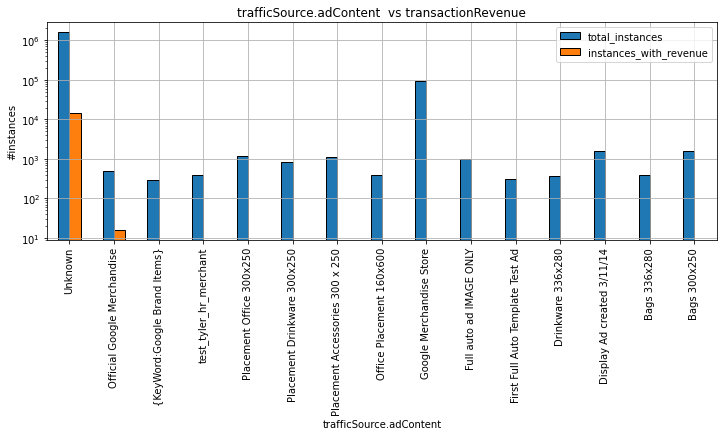

In [44]:
#trafficSource.adContent
cust_df['trafficSource.adContent'].fillna('Unknown',inplace=True)
agg_df = cust_df.groupby('trafficSource.adContent')['totals.transactionRevenue'].agg(['size','count'])
agg_df.columns = ['total_instances','instances_with_revenue']

sorted_agg_df = agg_df.sort_values(by=['instances_with_revenue','trafficSource.adContent'],ascending=False)
sorted_agg_df.head(40).plot(kind='bar',figsize=(12,4),title='trafficSource.adContent  vs transactionRevenue',logy=True,grid=True,edgecolor='black')
plt.ylabel('#instances')
plt.show()

<b>Summary</b>
<ul>
<li>Most of the revenue generated is from unknown adcontent followed by Offical Google Merchandise</li>
<li>Other categories of adcontent did not yield any revenue</li>
</ul>

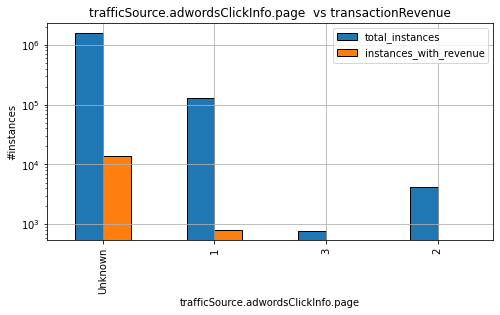

In [45]:
#trafficSource.adwordsClickInfo.page
cust_df['trafficSource.adwordsClickInfo.page'].fillna('Unknown',inplace=True)
agg_df = cust_df.groupby('trafficSource.adwordsClickInfo.page')['totals.transactionRevenue'].agg(['size','count'])
agg_df.columns = ['total_instances','instances_with_revenue']

sorted_agg_df = agg_df.sort_values(by=['instances_with_revenue','trafficSource.adwordsClickInfo.page'],ascending=False)
sorted_agg_df.plot(kind='bar',figsize=(8,4),title='trafficSource.adwordsClickInfo.page  vs transactionRevenue',logy=True,grid=True,edgecolor='black')
plt.ylabel('#instances')
plt.show()

<b>Summary</b>
<ul>
<li>Category is unknown for the most of the visits as well as revenue generating transactions</li>
</ul>

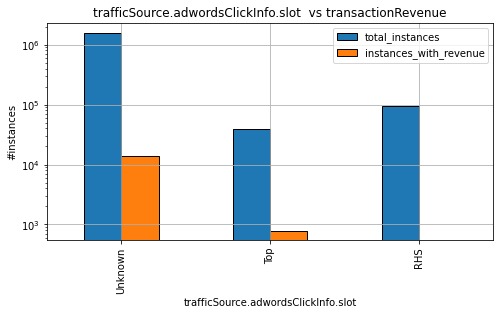

In [46]:
#trafficSource.adwordsClickInfo.slot 
cust_df['trafficSource.adwordsClickInfo.slot'].fillna('Unknown',inplace=True)
agg_df = cust_df.groupby('trafficSource.adwordsClickInfo.slot')['totals.transactionRevenue'].agg(['size','count'])
agg_df.columns = ['total_instances','instances_with_revenue']

sorted_agg_df = agg_df.sort_values(by=['instances_with_revenue','trafficSource.adwordsClickInfo.slot'],ascending=False)
sorted_agg_df.plot(kind='bar',figsize=(8,4),title='trafficSource.adwordsClickInfo.slot  vs transactionRevenue',logy=True,grid=True,edgecolor='black')
plt.ylabel('#instances')
plt.show()

<b>Summary</b>
<ul>
<li>Most frequent slot is unknown , followed by RHS and Top</li>
<li>Revenue generation is from unknown and Top category slots</li>
</ul>

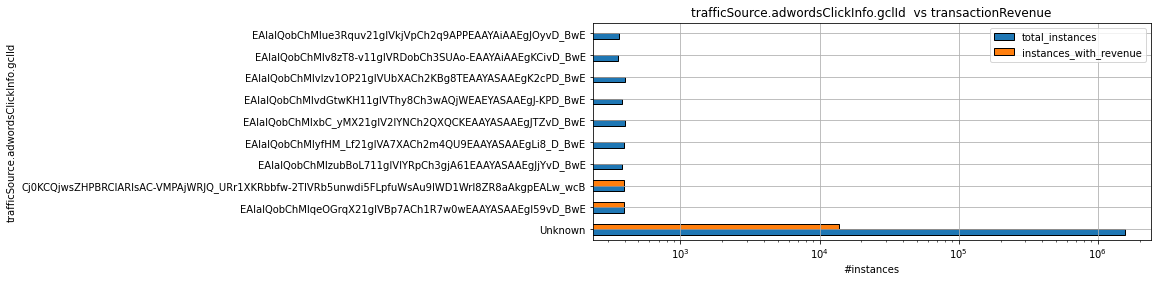

In [47]:
#trafficSource.adwordsClickInfo.gclId
cust_df['trafficSource.adwordsClickInfo.gclId'].fillna('Unknown',inplace=True)
agg_df = cust_df.groupby('trafficSource.adwordsClickInfo.gclId')['totals.transactionRevenue'].agg(['size','count'])
agg_df.columns = ['total_instances','instances_with_revenue']

sorted_agg_df = agg_df.sort_values(by=['instances_with_revenue','trafficSource.adwordsClickInfo.gclId'],ascending=False)
sorted_agg_df.head(10).plot(kind='barh',figsize=(10,4),title='trafficSource.adwordsClickInfo.gclId  vs transactionRevenue',logx=True,grid=True,edgecolor='black')
plt.xlabel('#instances')
plt.show()

<b>Summary</b>
<ul>
<li>gclID field is Unknown for majority of revenue generating transactions</li>
</ul>

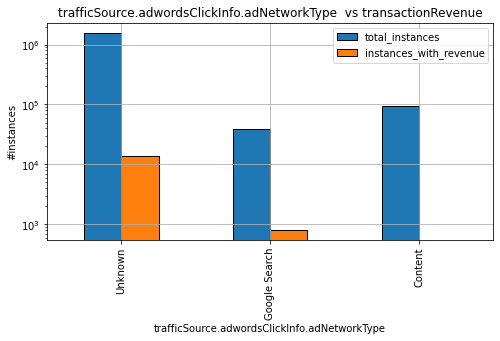

In [48]:
#trafficSource.adwordsClickInfo.adNetworkType 
cust_df['trafficSource.adwordsClickInfo.adNetworkType'].fillna('Unknown',inplace=True)
agg_df = cust_df.groupby('trafficSource.adwordsClickInfo.adNetworkType')['totals.transactionRevenue'].agg(['size','count'])
agg_df.columns = ['total_instances','instances_with_revenue']

sorted_agg_df = agg_df.sort_values(by=['instances_with_revenue','trafficSource.adwordsClickInfo.adNetworkType'],ascending=False)
sorted_agg_df.plot(kind='bar',figsize=(8,4),title='trafficSource.adwordsClickInfo.adNetworkType  vs transactionRevenue',logy=True,grid=True,edgecolor='black')
plt.ylabel('#instances')
plt.show()

<b>Summary</b>
<ul>
<li>For majority of the transactions adNetworkType is Unknown, Other categories include Google Search and content</li>
<li>Google Search has results in significant number of revenue generating transactions</li>
</ul>

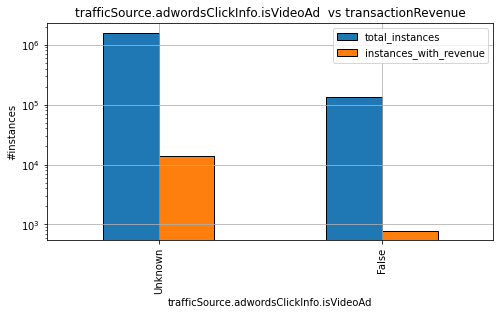

In [49]:
#trafficSource.adwordsClickInfo.isVideoAd
cust_df['trafficSource.adwordsClickInfo.isVideoAd'].fillna('Unknown',inplace=True)
agg_df = cust_df.groupby('trafficSource.adwordsClickInfo.isVideoAd')['totals.transactionRevenue'].agg(['size','count'])
agg_df.columns = ['total_instances','instances_with_revenue']

sorted_agg_df = agg_df.sort_values(by=['instances_with_revenue','trafficSource.adwordsClickInfo.isVideoAd'],ascending=False)
sorted_agg_df.plot(kind='bar',figsize=(8,4),title='trafficSource.adwordsClickInfo.isVideoAd  vs transactionRevenue',logy=True,grid=True,edgecolor='black')
plt.ylabel('#instances')
plt.show()

<b>Summary</b>
<ul>
<li>For a minor chunk of transactions , revenue is generated from Non Video Ads</li>
<li>Major chunk of revenue generated is from Unknown category</li>
</ul>

### Processing test dataset<a class="anchor" id="test"></a>

In [50]:
test_df = load_df('test_v2.csv')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


In [51]:
test_df = test_df.drop(['hits','customDimensions','totals.totalTransactionRevenue'],axis=1).compute()

In [52]:
#checking date column
test_df['date'] = test_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:]))) #year,month,day


In [53]:
#date
agg_df = test_df.groupby('date')['totals.transactionRevenue'].agg(['size','count'])
agg_df.columns = ['total_instances','instances_with_revenue']
sorted_agg_df = agg_df.sort_index()

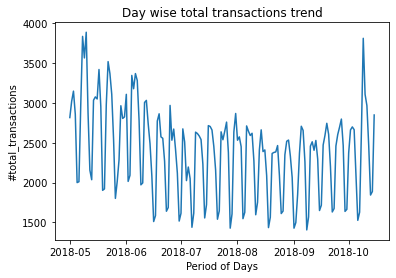

In [54]:
#https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.plot.html
plt.plot(sorted_agg_df.total_instances,scalex=True)
plt.title('Day wise total transactions trend')
plt.xlabel('Period of Days')
plt.ylabel('#total_transactions')
plt.show()

<b>Summary</b>
<ul>
<li>The instances of visits are following a descreasing trend till Jul-18, and partially increased in Aug-18</li>
<li>After Aug-18, we can observe an increasing instances trend of revenue.</li>
</ul>

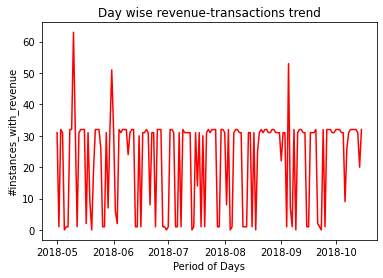

In [55]:
#https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.plot.html
plt.plot(sorted_agg_df.instances_with_revenue,scalex=True,color='red')
plt.title('Day wise revenue-transactions trend')
plt.xlabel('Period of Days')
plt.ylabel('#instances_with_revenue')
plt.show()

<b>Summary</b>
<ul>
<li>Few peaks are observed in May, Jun, and Sep-18 for transactions with non-zero revenue</li>
<li>We can observe a stable count of 30 non -zero revenue transactions for most of the period</li>
</ul>

In [56]:
#unique visitors in train and test
uniq_vis_train = cust_df['fullVisitorId'].nunique()
uniq_vis_test = test_df['fullVisitorId'].nunique()
print('No.of Unique visitors in train:',uniq_vis_train)
print('No.of Unique visitors in test:',uniq_vis_test)

No.of Unique visitors in train: 1323730
No.of Unique visitors in test: 296530


In [57]:
#Common Visitors in train and test
tr_vis = unique_cust['fullVisitorId'].values
te_vis = test_df['fullVisitorId'].unique()
print('No.of common visitors in train and test:',len(set(tr_vis).intersection(set(te_vis))))

No.of common visitors in train and test: 2759


<h2> Modeling </h2><a class="anchor" id="modeling"></a>

<h3> Applying Linear Regression </h3><a class="anchor" id="linearreg"></a>

In [58]:
#Dropping constant columns
cust_df = cust_df.drop(single_valued_cols,axis=1)

In [59]:
cust_df.shape

(1708337, 37)

In [60]:
single_valued_cols.remove('trafficSource.campaignCode')
test_df = test_df.drop(single_valued_cols,axis=1)

In [61]:
test_df.shape

(401589, 37)

In [62]:
#categorical columns
catgry_cols = ["channelGrouping", "device.browser", 
            "device.deviceCategory", "device.operatingSystem", 
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", "trafficSource.adContent", 
            "trafficSource.adwordsClickInfo.adNetworkType", 
            "trafficSource.adwordsClickInfo.gclId", 
            "trafficSource.adwordsClickInfo.page", 
            "trafficSource.adwordsClickInfo.slot", "trafficSource.campaign",
            "trafficSource.keyword", "trafficSource.medium", 
            "trafficSource.referralPath", "trafficSource.source",
            "trafficSource.adwordsClickInfo.isVideoAd", "trafficSource.isTrueDirect"]

numeric_cols = ["totals.hits", "totals.pageviews", "visitNumber", "visitStartTime", "totals.bounces",  "totals.newVisits"]

In [63]:
#https://www.kaggle.com/prashantkikani/ensembling-fe-is-the-answer
#Factorizing of categorical columns
catenc_dict = {}
for col in catgry_cols:
    cust_df[col],indexer = pd.factorize(cust_df[col])
    catenc_dict[col] = indexer
    test_df[col] = indexer.get_indexer(test_df[col])

In [64]:
import joblib
dict_file = 'catencoder.file'
joblib.dump(catenc_dict,dict_file)

['catencoder.file']

In [65]:
cust_df[catgry_cols].head()

,channelGrouping,device.browser,device.deviceCategory,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.isTrueDirect
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
1,1,1,0,1,1,1,1,1,0,1,1,0,0,0,0,0,0,1,1,1,1,0,-1
2,2,1,1,2,0,1,1,0,1,0,1,0,0,0,0,0,0,1,2,0,2,0,0
3,0,1,0,0,0,2,2,0,2,0,2,0,0,0,0,0,0,2,0,0,0,0,-1
4,0,1,0,0,0,1,3,0,3,0,3,0,0,0,0,0,0,2,0,0,0,0,-1


In [66]:
for col in numeric_cols:
    cust_df[col].fillna(0,inplace=True)
    test_df[col] = test_df[col].astype(float)
    test_df[col].fillna(0,inplace=True)

In [67]:
cust_df['totals.transactionRevenue'].fillna(0,inplace=True) #fill nan transactions with 0

In [68]:
clf = LinearRegression()
clf.fit(cust_df[catgry_cols+numeric_cols],np.log1p(cust_df['totals.transactionRevenue']))

LinearRegression()

In [69]:
dpreds_lr = clf.predict(cust_df[catgry_cols+numeric_cols])
preds_lr = clf.predict(test_df[catgry_cols+numeric_cols])

In [70]:
test_df['totals.transactionRevenue'] = test_df['totals.transactionRevenue'].astype('float')
test_df['totals.transactionRevenue'].fillna(0,inplace=True) #fill nan transactions with 0
test_df['totals.transactionRevenue'] = np.log1p(test_df['totals.transactionRevenue'])
test_uniq_df = test_df.groupby('fullVisitorId')['totals.transactionRevenue'].sum().reset_index()

In [71]:
test_uniq_df.tail(3)

,fullVisitorId,totals.transactionRevenue
296527,999990167740728398,0.0
296528,9999915620249883537,0.0
296529,9999947552481876143,0.0


In [72]:
def calculateRMSE(predictions,trainorVal):
    """Function to calculate RMSLE - metric"""
    predictions[predictions<0] = 0
    if trainorVal == 'test':
        #print('test RMSE')
        test_df['PredRevenue'] = predictions
        agg_df = test_df.groupby('fullVisitorId')["totals.transactionRevenue","PredRevenue"].sum().reset_index()
        return np.sqrt(mse(agg_df['totals.transactionRevenue'].values,agg_df['PredRevenue'].values))
    elif trainorVal == 'val':
        #print('Val RMSE')
        val_pred_df = pd.DataFrame({"fullVisitorId":val_df["fullVisitorId"].values})
        val_pred_df["transactionRevenue"] = np.log1p(val_df["totals.transactionRevenue"].values)
        val_pred_df["PredRevenue"] = predictions
        val_pred_df = val_pred_df.groupby('fullVisitorId')["transactionRevenue","PredRevenue"].sum().reset_index()
        return np.sqrt(mse(val_pred_df['transactionRevenue'].values,val_pred_df['PredRevenue'].values))
    elif trainorVal == 'train':
        train_pred_df = pd.DataFrame({"fullVisitorId":cust_df["fullVisitorId"].values})
        train_pred_df["transactionRevenue"] = np.log1p(cust_df["totals.transactionRevenue"].values)
        train_pred_df["PredRevenue"] = predictions
        train_pred_df = train_pred_df.groupby('fullVisitorId')["transactionRevenue","PredRevenue"].sum().reset_index()
        return np.sqrt(mse(train_pred_df['transactionRevenue'].values,train_pred_df['PredRevenue'].values))
    else:
        #print('Dev RMSE')
        dev_pred_df = pd.DataFrame({"fullVisitorId":dev_df["fullVisitorId"].values})
        dev_pred_df["transactionRevenue"] = np.log1p(dev_df["totals.transactionRevenue"].values)
        dev_pred_df["PredRevenue"] = predictions
        dev_pred_df = dev_pred_df.groupby('fullVisitorId')["transactionRevenue","PredRevenue"].sum().reset_index()
        return np.sqrt(mse(dev_pred_df['transactionRevenue'].values,dev_pred_df['PredRevenue'].values))

In [73]:
def generateSubmissionFile(algo,predictions):
    """Funtion to generate submission file to kaggle."""
    sub_df = pd.DataFrame({"fullVisitorId":test_df['fullVisitorId']}) #test data
    predictions[predictions<0] = 0 
    sub_df["PredictedLogRevenue"] = predictions
    sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
    sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
    filename = "sub_"+algo+".csv"
    sub_df.to_csv(filename, index=False)
    rmsle = np.sqrt(mse(test_uniq_df['totals.transactionRevenue'].values,sub_df['PredictedLogRevenue'].values))
    return rmsle

In [74]:
print("Train RMSLE",calculateRMSE(dpreds_lr,'train'))
print("Test RMSLE",calculateRMSE(preds_lr,'test'))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


Train RMSLE 1.6710543479628526


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


Test RMSLE 1.864318677504951


In [92]:
#generate submission df and calculate rmsle metric
rmsle_lr = generateSubmissionFile('LR',preds_lr)

In [93]:
rmsle_lr

1.8643186775049971

<b> kaggle score for Basic Linear Regression </b>
<img src="https://i.imgur.com/LgTJK0w.png"/>

<h3> Applying Ridge Regression </h3><a class="anchor" id="ridgReg"></a>

In [100]:
num_cols = ["totals.hits", "totals.pageviews", "visitNumber", "totals.bounces",  "totals.newVisits"]

In [101]:
ridge_params = { 'alpha' : [0.01, 0.05, 0.1, 0.3, 0.5, 0.7] } 
clfRidge = Ridge(normalize=True)
grid = GridSearchCV(clfRidge, ridge_params,cv=5)
grid.fit(cust_df[catgry_cols+num_cols],np.log1p(cust_df['totals.transactionRevenue']))
print("Best Params:",grid.best_params_)

Best Params: {'alpha': 0.01}


In [102]:
bestClfRidge = Ridge(normalize=True,alpha = grid.best_params_['alpha'])
bestClfRidge.fit(cust_df[catgry_cols+num_cols],np.log1p(cust_df['totals.transactionRevenue']))

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=True, random_state=None, solver='auto', tol=0.001)

In [103]:
dpreds_lrRidge = bestClfRidge.predict(cust_df[catgry_cols+num_cols])
preds_lrRidge = bestClfRidge.predict(test_df[catgry_cols+num_cols])

In [104]:
print("Train RMSLE",calculateRMSE(dpreds_lrRidge,'train'))
print("Test RMSLE",calculateRMSE(preds_lrRidge,'test'))

Train RMSLE 1.6728888822193642
Test RMSLE 1.8697743552789166


In [105]:
rmsle_lrRidge = generateSubmissionFile('LR_Ridge',preds_lrRidge)

In [106]:
rmsle_lrRidge

1.8697743552789166

<b>kaggle score for Ridge Regression</b>
<img src="https://i.imgur.com/85mgL6I.png"/>

<h3>Applying xgboost Regressor</h3> <a class="anchor" id="xgbReg"></a>

In [109]:
cluster = LocalCluster()
client = Client(cluster)

In [75]:
# Split the train dataset into development and valid based on time 
dev_df = cust_df[cust_df['date']<=datetime.date(2017,12,31)]
val_df = cust_df[cust_df['date']>datetime.date(2017,12,31)]
dev_y = np.log1p(dev_df["totals.transactionRevenue"].values)
val_y = np.log1p(val_df["totals.transactionRevenue"].values)

dev_X = dev_df[catgry_cols+numeric_cols] 
val_X = val_df[catgry_cols+numeric_cols] 
test_X = test_df[catgry_cols+numeric_cols] 

In [76]:
print("Train shape:",dev_X.shape)

Train shape: (1365253, 29)


In [77]:
print("Val shape:",val_X.shape)

Val shape: (343084, 29)


<h4> Running XGBRegressor </h4>

In [97]:
#https://xgboost.readthedocs.io/en/latest/python/python_api.html
#https://www.analyticsvidhya.com/blog/2018/08/dask-big-datasets-machine_learning-python/
with parallel_backend('dask'):
    default_xgb_model = XGBRegressor(objective = "reg:squarederror", seed=33)
    default_xgb_model.fit(dev_X,dev_y,eval_metric="rmse")
    dev_preds_xgb = default_xgb_model.predict(dev_X)
    val_preds_xgb = default_xgb_model.predict(val_X)
    test_preds_xgb = default_xgb_model.predict(test_X)

In [98]:
#dev rmsle
print("Dev - RMSLE:",calculateRMSE(dev_preds_xgb,'dev'))
#val rmsle
print("Val - RMSLE:",calculateRMSE(val_preds_xgb,'val'))
#test rmsle
print("Test - RMSLE:",calculateRMSE(test_preds_xgb,'test'))

Dev - RMSE: 1.1577539060996387
Val - RMSE: 1.2005901527011882
Test - RMSE: 1.883432126562691


In [99]:
rmsle_xgboost = generateSubmissionFile('xgboost',test_preds_xgb)

In [95]:
print("Test RMSLE(xgb):",rmsle_xgboost)

Test RMSLE(xgb): 1.883432126562691


<b> kaggle score for XGBRegressor </b>
<img src="https://i.imgur.com/tVRKY9d.png"/>

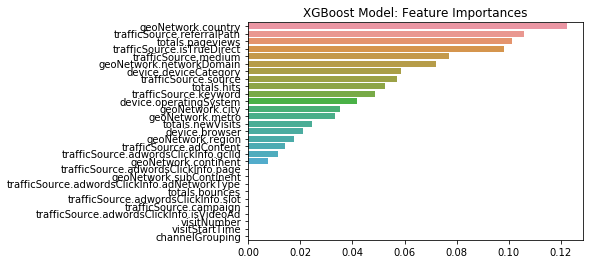

In [102]:
sorted_indices = np.argsort(default_xgb_model.feature_importances_)
feature_names = np.array(catgry_cols+numeric_cols)
sns.barplot(x=default_xgb_model.feature_importances_[sorted_indices][::-1],y=feature_names[sorted_indices][::-1])
plt.title("XGBoost Model: Feature Importances")
plt.show()

#### HyperParameter Tuning XGBRegressor

In [111]:
#Hyperparameter tuning using simple cross validation
with parallel_backend('dask'):
    n_estimators = [300,500,1000]
    max_depth = [5,7,9]
    xgbt_dev_rmse = []
    xgbt_val_rmse = []
    #simple hyperparameter search
    for est in n_estimators:
        for depth in max_depth:
            xgb_reg = XGBRegressor(n_estimators=est,
                                   max_depth=depth,
                                   objective = 'reg:squarederror',
                                   seed=33) 
            xgb_reg.fit(dev_X,dev_y,eval_metric="rmse")
    
            xgbt_pred_dev_y = xgb_reg.predict(dev_X)
            xgbt_pred_val_y = xgb_reg.predict(val_X)
            
            xgbt_dev_rmse.append(calculateRMSE(xgbt_pred_dev_y,'dev'))
            xgbt_val_rmse.append(calculateRMSE(xgbt_pred_val_y,'val'))

In [107]:
def plotModelPerfForBestHyperParam(data,train_cvdata,modelName):
    """heatmap to visualize model performance with varying haperparameters"""
    #formatting data to be displayed on heatmap grids to 4 decimal places
    annotlabels = (np.asarray(["{0:.4f}".format(x) for x in data.flatten()])).reshape(len(n_estimators),len(max_depth))
    if train_cvdata == 'Train':
        colors = 'Blues'
    else:
        colors = 'Greens'
    plt.figure(figsize=(20,8))
    ax = sns.heatmap(data,annot=annotlabels,fmt='',xticklabels=max_depth,yticklabels=n_estimators,cmap=colors,linewidth=0.1,linecolor='white')
    #https://datascience.stackexchange.com/questions/57245/seaborn-heatmap-not-displaying-correctly
    ax.set_ylim([0,len(n_estimators)]) #if values are overlapping with grid.. 3 is no.of points considered on y-axis
    ax.set_xlabel('max_depth')
    ax.set_ylabel('n_estimators')
    ax.set_title(modelName+" performance on "+train_cvdata+" data")
    plt.show()

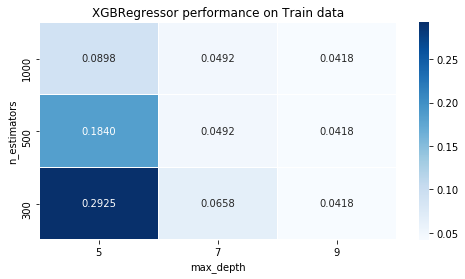

In [112]:
plotModelPerfForBestHyperParam(np.array(xgbt_dev_rmse).reshape(3,3),'Train','XGBRegressor')

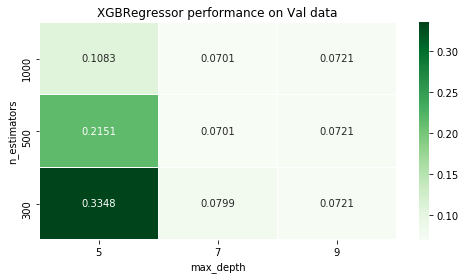

In [113]:
plotModelPerfForBestHyperParam(np.array(xgbt_val_rmse).reshape(3,3),'Val','XGBRegressor')

Best Parameters:
    max_depth : 7, n_estimators : 300
 <br>
  Minimum difference in RMSLE values between test and validation data 

In [114]:
#run model with best hyper-parameters
with parallel_backend('dask'):
    best_xgb_model = XGBRegressor(max_depth=7,
                                  n_estimators=300,
                                  objective = "reg:squarederror",
                                  seed=33)
    best_xgb_model.fit(dev_X,dev_y,eval_metric='rmse')
    dev_preds_xgbt = best_xgb_model.predict(dev_X)
    val_preds_xgbt = best_xgb_model.predict(val_X)
    test_preds_xgbt = best_xgb_model.predict(test_X)

In [115]:
print("Dev RMLSE:",calculateRMSE(dev_preds_xgbt,'dev'))
print("Val RMSLE:",calculateRMSE(val_preds_xgbt,'val'))
print("Test RMSLE:",calculateRMSE(test_preds_xgbt,'test'))

Dev RMLSE: 0.06581497764070474
Val RMSLE: 0.0799007257652025
Test RMSLE: 1.9167253519206064


In [116]:
rmsle_xgbtuned = generateSubmissionFile('xgb_tuned',test_preds_xgbt)

In [117]:
print("Test RMSLE(xgb_tuned):",rmsle_xgbtuned)

Test RMSLE(xgb_tuned): 1.9167253519206064


<b> kaggle score for xgb tuned </b>
<img src="https://i.imgur.com/y4Dylqd.png"/>

#### Tuning learning_rate

In [118]:
learning_rates = [0.0001, 0.001, 0.01, 0.1]

In [119]:
xgblr_dev_rmse = []
xgblr_val_rmse = []
for eta in learning_rates:
    xgblr_reg = XGBRegressor(learning_rate=eta,
                           n_estimators=300,
                           max_depth=7,
                           objective = 'reg:squarederror',
                           seed=33) 
    xgblr_reg.fit(dev_X,dev_y,eval_metric='rmse')

    xgblr_pred_dev_y = xgblr_reg.predict(dev_X)
    xgblr_pred_val_y = xgblr_reg.predict(val_X)

    xgblr_dev_rmse.append(calculateRMSE(xgblr_pred_dev_y,'dev'))
    xgblr_val_rmse.append(calculateRMSE(xgblr_pred_val_y,'val'))

In [124]:
def plotModelPerfForBestLearningRate(train_metric,cv_metric,modelType):
    plt.plot(learning_rates, train_metric, label='Dev RMSLE')
    plt.plot(learning_rates, cv_metric, label='Val RMSLE')
    plt.scatter(learning_rates, train_metric, label='Dev RMSLE Points')
    plt.scatter(learning_rates, cv_metric, label='Val RMSLE Points')
    plt.legend()
    plt.xlabel("learning_rate")
    plt.ylabel("RMSLE")
    plt.title("Performance Plot for "+modelType+" model")
    plt.grid()
    plt.show()

In [81]:
def plotModelPerfForBestMaxDepth(train_metric,cv_metric,modelType):
    plt.plot(max_depth_tuning, train_metric, label='Dev RMSLE')
    plt.plot(max_depth_tuning, cv_metric, label='Val RMSLE')
    plt.scatter(max_depth_tuning, train_metric, label='Dev RMSLE Points')
    plt.scatter(max_depth_tuning, cv_metric, label='Val RMSLE Points')
    plt.legend()
    plt.xlabel("max_depth")
    plt.ylabel("RMSLE")
    plt.title("Performance Plot for "+modelType+" model")
    plt.grid()
    plt.show()

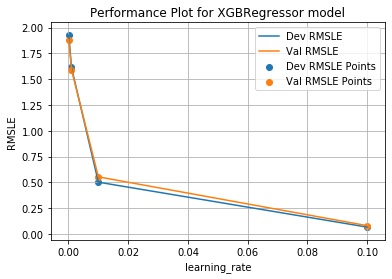

In [123]:
plotModelPerfForBestLearningRate(xgblr_dev_rmse,xgblr_val_rmse, 'XGBRegressor')

Observation:
    From the above plot, best learning_rate is 0.1

In [125]:
#run model with best hyper-parameters
with parallel_backend('dask'):
    best_xgblr_model = XGBRegressor(learning_rate = 0.1, #tuned
                                  max_depth=7,
                                  n_estimators=300,
                                  objective = "reg:squarederror",
                                  seed=33)
    best_xgblr_model.fit(dev_X,dev_y,eval_metric='rmse')
    dev_preds_xgblr = best_xgblr_model.predict(dev_X)
    val_preds_xgblr = best_xgblr_model.predict(val_X)
    test_preds_xgblr = best_xgblr_model.predict(test_X)

In [126]:
print("Dev RMSLE:",calculateRMSE(dev_preds_xgblr,'dev'))
print("Val RMSLE:",calculateRMSE(val_preds_xgblr,'val'))
print("Test RMSLE:",calculateRMSE(test_preds_xgblr,'test'))

Dev RMSLE: 0.06581497764070474
Val RMSLE: 0.0799007257652025
Test RMSLE: 1.9167253519206064


In [127]:
rmsle_xgbfinetuned = generateSubmissionFile('xgb_finetuned',test_preds_xgblr)
print("Test RMSLE(xgbfinetuned):",rmsle_xgbfinetuned)

Test RMSLE(xgbfinetuned): 1.9167253519206064


<b>kaggle score for xgb tuned learning_rate</b>
<img src="https://i.imgur.com/q6o2v2h.png"/>

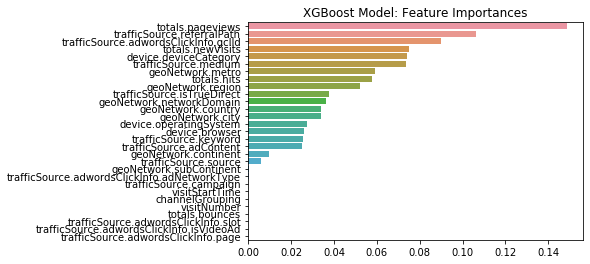

In [134]:
sorted_indices = np.argsort(best_xgblr_model.feature_importances_)
feature_names = np.array(catgry_cols+numeric_cols)
sns.barplot(x=best_xgblr_model.feature_importances_[sorted_indices][::-1],y=feature_names[sorted_indices][::-1])
plt.title("XGBoost Model: Feature Importances")
plt.show()

#### Tuning max_depth parameter

In [177]:
max_depth_tuning = [5,7,9,11,13,15,17,19,21,23,25,27,29]

In [178]:
xgbd_dev_rmse = []
xgbd_val_rmse = []
for depth in max_depth_tuning:
    xgbd_reg = XGBRegressor(learning_rate=0.1,
                           n_estimators=300,
                           max_depth=depth,
                           objective = 'reg:squarederror',
                           seed=33) 
    xgbd_reg.fit(dev_X,dev_y,eval_metric='rmse')

    xgbd_pred_dev_y = xgbd_reg.predict(dev_X)
    xgbd_pred_val_y = xgbd_reg.predict(val_X)

    xgbd_dev_rmse.append(calculateRMSE(xgbd_pred_dev_y,'dev'))
    xgbd_val_rmse.append(calculateRMSE(xgbd_pred_val_y,'val'))

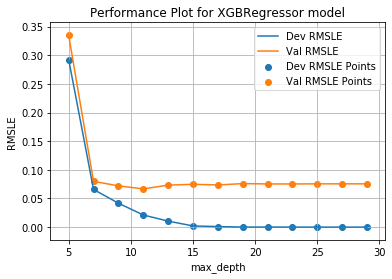

In [179]:
plotModelPerfForBestMaxDepth(xgbd_dev_rmse,xgbd_val_rmse, 'XGBRegressor')

Best max_depth: 9

In [184]:
#run model with best hyper-parameters
best_xgbd_model = XGBRegressor(learning_rate = 0.1, 
                              max_depth=9,
                              n_estimators=300,
                              objective = "reg:squarederror",
                              seed=33)
best_xgbd_model.fit(dev_X,dev_y,eval_metric='rmse')
dev_preds_xgbd = best_xgbd_model.predict(dev_X)
val_preds_xgbd = best_xgbd_model.predict(val_X)
test_preds_xgbd = best_xgbd_model.predict(test_X)

In [185]:
print("Dev RMSLE:",calculateRMSE(dev_preds_xgbd,'dev'))
print("Val RMSLE:",calculateRMSE(val_preds_xgbd,'val'))
print("Test RMSLE:",calculateRMSE(test_preds_xgbd,'test'))

Dev RMSLE: 0.041798571826614055
Val RMSLE: 0.07205039825616363
Test RMSLE: 2.0419469595514816


In [186]:
rmsle_xgbd = generateSubmissionFile('xgb_depth',test_preds_xgbd)
print("Test RMSLE(xgb_depth):",rmsle_xgbd)

Test RMSLE(xgb_depth): 2.0419469595514816


##### kaggle score for xgb(tuned max_depth)
<img src="https://i.imgur.com/4kUJGC4.png"/>

#### Saving the best model

In [128]:
#saving model 
joblib.dump(best_xgblr_model,'xgboost.model')

['xgboost.model']

In [129]:
#retrieving saved model
bst_xgb_model = joblib.load('xgboost.model')

In [130]:
#testing saved model
bst_pred_test_y = bst_xgb_model.predict(test_X)

In [131]:
calculateRMSE(bst_pred_test_y,'test')

1.9167253519206064

<h3>Applying LGBMRegressor</h3> <a class="anchor" id="lgbmReg"></a>

#### Running LGBMRegressor 

In [135]:
with parallel_backend('dask'):
    def_lgbm_model = lgb.LGBMRegressor(objective = "regression",
                                  seed=33)
    def_lgbm_model.fit(dev_X,dev_y,eval_metric='rmse')
    dev_preds_lgbm = def_lgbm_model.predict(dev_X)
    val_preds_lgbm = def_lgbm_model.predict(val_X)
    test_preds_lgbm = def_lgbm_model.predict(test_X)
   

In [136]:
print("Dev RMSLE:",calculateRMSE(dev_preds_lgbm,'dev'))
print("Val RMSLE:",calculateRMSE(val_preds_lgbm,'val'))
print("Test RMSLE:",calculateRMSE(test_preds_lgbm,'test'))

Dev RMSLE: 0.21052049166146608
Val RMSLE: 0.25393892631257303
Test RMSLE: 2.0375805161709337


In [137]:
rmsle_lgbm = generateSubmissionFile('lightgbm',test_preds_lgbm)

In [138]:
print("Test - RMSE:",rmsle_lgbm)

Test - RMSE: 2.0375805161709337


<b> kaggle score for light gbm Regressor </b>
<img src="https://i.imgur.com/q5B1d74.png"/>

#### Tuning LGBMRegressor

In [102]:
#Tuning lgbm
n_estimators = [150,300,500,1000,1500]
max_depth = [5,7,9,11,13,15,17,19,21,23,25,27,29]
lgbmt_dev_rmse = []
lgbmt_val_rmse = []
#simple hyperparameter search
for est in n_estimators:
    for depth in max_depth:
        lgbm_reg = lgb.LGBMRegressor(n_estimators=est,
                               max_depth=depth,
                               objective = 'regression',
                               seed=33) 
        lgbm_reg.fit(dev_X,dev_y,eval_metric='rmse')

        lgbmt_pred_dev_y = lgbm_reg.predict(dev_X)
        lgbmt_pred_val_y = lgbm_reg.predict(val_X)

        lgbmt_dev_rmse.append(calculateRMSE(lgbmt_pred_dev_y,'dev'))
        lgbmt_val_rmse.append(calculateRMSE(lgbmt_pred_val_y,'val'))

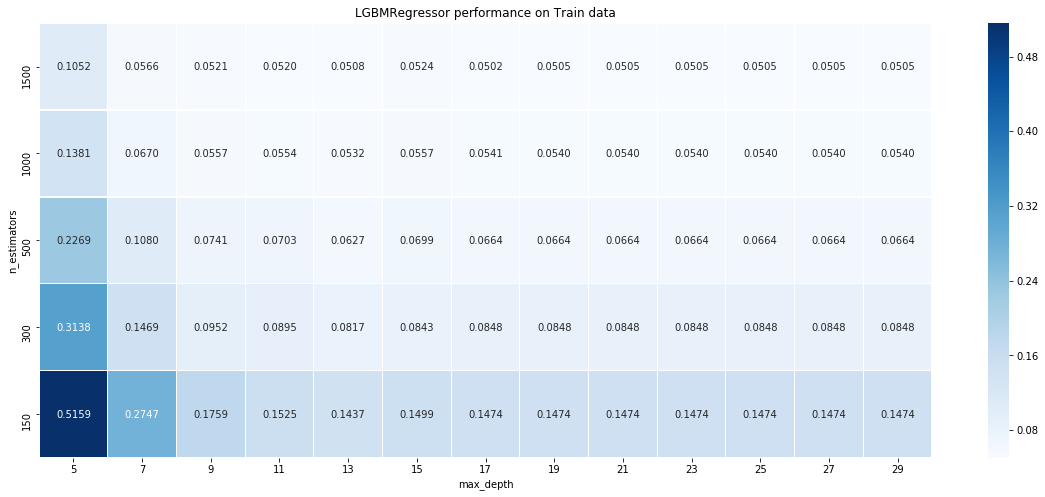

In [108]:
plotModelPerfForBestHyperParam(np.array(lgbmt_dev_rmse).reshape(len(n_estimators),len(max_depth)),'Train','LGBMRegressor')

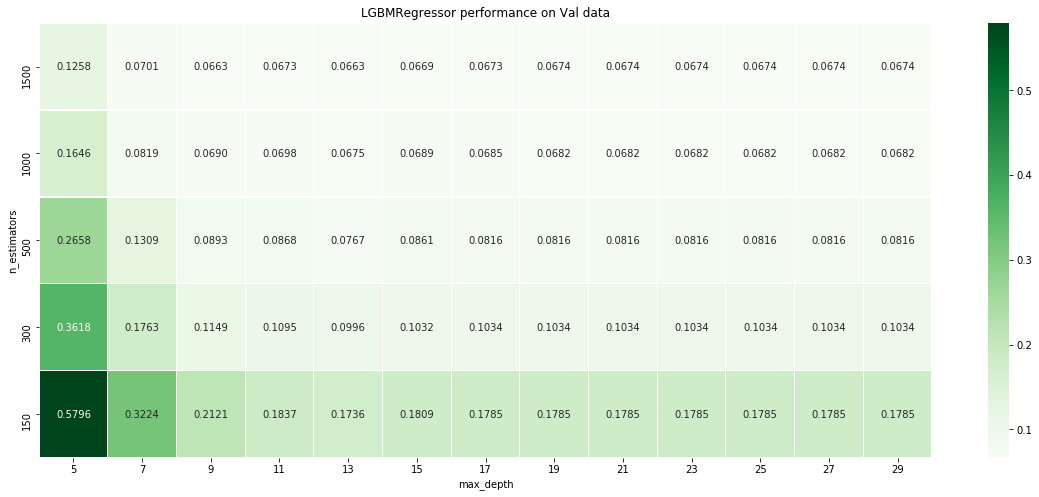

In [109]:
plotModelPerfForBestHyperParam(np.array(lgbmt_val_rmse).reshape(len(n_estimators),len(max_depth)),'Val','LGBMRegressor')

Observation:<br>
    Best parameters : max_depth : 15, n_estimators : 1500

In [113]:
#run model with best hyper-parameters
best_lgbm_model = lgb.LGBMRegressor(max_depth=15,
                              n_estimators=1500,
                              objective = "regression",
                              seed=33)
best_lgbm_model.fit(dev_X,dev_y,eval_metric='rmse')
dev_preds_lgbmt = best_lgbm_model.predict(dev_X)
val_preds_lgbmt = best_lgbm_model.predict(val_X)
test_preds_lgbmt = best_lgbm_model.predict(test_X)

In [119]:
print("Dev RMSLE:",calculateRMSE(dev_preds_lgbmt,'dev'))
print("Val RMSLE:",calculateRMSE(val_preds_lgbmt,'val'))
print("Test RMSLE:",calculateRMSE(test_preds_lgbmt,'test'))

Dev RMSLE: 0.05236075192805579
Val RMSLE: 0.06691278937268137
Test RMSLE: 2.0102876438880064


In [120]:
rmsle_lgbtuned = generateSubmissionFile('lgbm_tuned',test_preds_lgbmt)
print("Test RMSLE(lgbmtuned):",rmsle_lgbtuned)

Test RMSLE(lgbmtuned): 2.0102876438880064


<b> kaggle score for tuned lgbm Regressor </b>
<img src="https://i.imgur.com/3wBtreg.png"/>

#### Tuning Learning Rate

In [163]:
learning_rates = [0.0001,0.001,0.01]

In [164]:
lgbmlr_dev_rmse = []
lgbmlr_val_rmse = []
for eta in learning_rates:
    lgbmlr_reg = lgb.LGBMRegressor(learning_rate=eta,
                           n_estimators=1500,
                           max_depth=15,
                           objective = 'regression',
                           seed=33) 
    lgbmlr_reg.fit(dev_X,dev_y,eval_metric='rmse')

    lgbmlr_pred_dev_y = lgbmlr_reg.predict(dev_X)
    lgbmlr_pred_val_y = lgbmlr_reg.predict(val_X)

    lgbmlr_dev_rmse.append(calculateRMSE(lgbmlr_pred_dev_y,'dev'))
    lgbmlr_val_rmse.append(calculateRMSE(lgbmlr_pred_val_y,'val'))

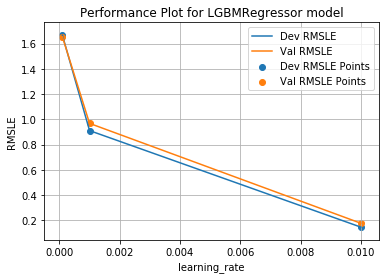

In [165]:
plotModelPerfForBestLearningRate(lgbmlr_dev_rmse,lgbmlr_val_rmse, 'LGBMRegressor')

In [117]:
#run model with best hyper-parameters
best_lgbmlr_model = lgb.LGBMRegressor(learning_rate = 0.001, #tuned - best RMSLE observed
                              max_depth=15,
                              n_estimators=1500,
                              objective = "regression",
                              seed=33)
best_lgbmlr_model.fit(dev_X,dev_y,eval_metric='rmse')
dev_preds_lgbmlr = best_lgbmlr_model.predict(dev_X)
val_preds_lgbmlr = best_lgbmlr_model.predict(val_X)
test_preds_lgbmlr = best_lgbmlr_model.predict(test_X)

In [118]:
print("Dev RMSLE:",calculateRMSE(dev_preds_lgbmlr,'dev'))
print("Val RMSLE:",calculateRMSE(val_preds_lgbmlr,'val'))
print("Test RMSLE:",calculateRMSE(test_preds_lgbmlr,'test'))

Dev RMSLE: 0.9111764105052427
Val RMSLE: 0.9684595711344709
Test RMSLE: 1.9274394479723826


In [172]:
rmsle_lgbmfinetuned = generateSubmissionFile('lgbm_finetuned',test_preds_lgbmlr)
print("Test RMSLE(lgbmfinetuned):",rmsle_lgbmfinetuned)

Test RMSLE(lgbmfinetuned): 1.9274394479723826


<b> kaggle score for tuned(learning_rate) lgbm Regressor </b>
<img src="https://i.imgur.com/kIKcEUP.png"/>

#### Saving the best model

In [173]:
#saving model file
joblib.dump(best_lgbmlr_model,'lightgbm.model')

['lightgbm.model']

In [174]:
#loading the saved model
bst_lgb_model = joblib.load('lightgbm.model')

In [175]:
best_lgb_pred_test_y = bst_lgb_model.predict(test_X)
print("Test - RMSLE:",calculateRMSE(best_lgb_pred_test_y,'test'))

Test - RMSLE: 1.9274394479723826


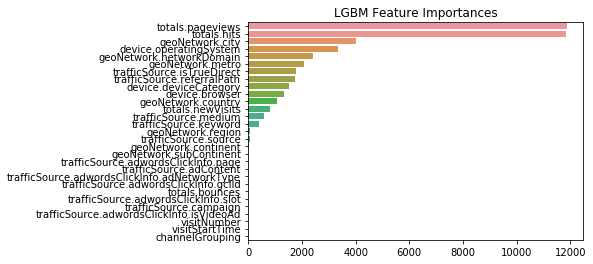

In [176]:
sorted_indices = np.argsort(bst_lgb_model.feature_importances_)
feature_names = np.array(catgry_cols+numeric_cols)
sns.barplot(x=bst_lgb_model.feature_importances_[sorted_indices][::-1],y=feature_names[sorted_indices][::-1])
plt.title("LGBM Feature Importances")
plt.show()

#### Using RandomSearchCV on a sample data

In [166]:
#Running Hyperparameter search using RandomSearchCV with a sample 80% data

cust_df_sample = cust_df.sample(frac=0.80)
tr_y = np.log1p(cust_df_sample["totals.transactionRevenue"].values)
tr_X = cust_df_sample[catgry_cols+numeric_cols] 
param_test ={'num_leaves': sp_randint(6, 50),
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
             'learning_rate': [10**y for y in range(-5,2)],
             'max_depth': [y for y in range(3,15,2)]}

gs = RandomizedSearchCV(
    estimator=bst_lgb_model, param_distributions=param_test, 
    n_iter=5,
    #scoring='neg_mean_squared_log_error', #failing for negative values
    scoring='neg_mean_absolute_error',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)
gs.fit(tr_X,tr_y)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  8.7min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.01, max_depth=9,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=500,
                                           n_jobs=-1, num_leaves=31,
                                           objective='regression',
                                           random_state=None, reg_alpha=...
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa3e41c90d0>,
                                        'reg_alpha': [0

In [167]:
gs.best_estimator_

LGBMRegressor(boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.6879091728281055, importance_type='split',
              learning_rate=0.01, max_depth=9, min_child_samples=109,
              min_child_weight=10.0, min_split_gain=0.0, n_estimators=500,
              n_jobs=-1, num_leaves=10, objective='regression',
              random_state=None, reg_alpha=1, reg_lambda=0.1, seed=33,
              silent=True, subsample=0.6775057521029393,
              subsample_for_bin=200000, subsample_freq=0)

In [168]:
with parallel_backend('dask'):
    gs.best_estimator_.fit(dev_X,dev_y,eval_metric='rmse')
    dev_preds_lgbmRS = gs.best_estimator_.predict(dev_X)
    val_preds_lgbmRS = gs.best_estimator_.predict(val_X)
    test_preds_lgbmRS = gs.best_estimator_.predict(test_X)

In [169]:
print("Dev RMSLE:",calculateRMSE(dev_preds_lgbmRS,'dev'))
print("Val RMSLE:",calculateRMSE(val_preds_lgbmRS,'val'))
print("Test RMSLE:",calculateRMSE(test_preds_lgbmRS,'test'))

Dev RMSLE: 1.0214386546576588
Val RMSLE: 1.0822129879580509
Test RMSLE: 1.8448787346452167


In [170]:
rmsle_lgbmrandomsrch = generateSubmissionFile('lgbm_randomsrch',test_preds_lgbmRS)
print("Test RMSLE(lgbm_randomsrch):",rmsle_lgbmrandomsrch)

Test RMSLE(lgbm_randomsrch): 1.8448787346452167


<b> kaggle score for lgbm with 80% sample train data tuned with radomsearchcv </b>
<img src="https://i.imgur.com/B25ydQU.png"/>

<h3>Applying RandomForestRegressor</h3> <a class="anchor" id="rfReg"></a>

<h4> Tuning RandomForest Regressor </h4>

In [172]:
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
with parallel_backend('dask'):
    n_estimators = [150,300,500]
    max_depth = [3,5,7]
    dev_rmse = []
    val_rmse = []
    #simple hyperparameter search
    for est in n_estimators:
        for depth in max_depth:
            rf_reg = RandomForestRegressor(n_estimators=est,criterion="mse",max_depth=depth,random_state=33) 
            rf_reg.fit(dev_X,dev_y)
    
            rf_pred_dev_y = rf_reg.predict(dev_X)
            rf_pred_val_y = rf_reg.predict(val_X)
            
            dev_rmse.append(calculateRMSE(rf_pred_dev_y,'dev'))
            val_rmse.append(calculateRMSE(rf_pred_val_y,'val'))

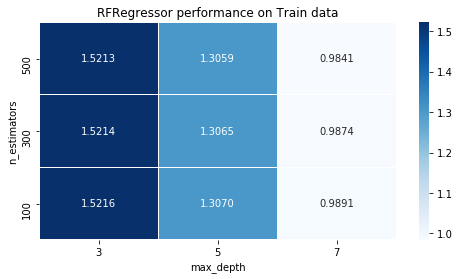

In [173]:
plotModelPerfForBestHyperParam(np.array(dev_rmse).reshape(3,3),'Train','RFRegressor')

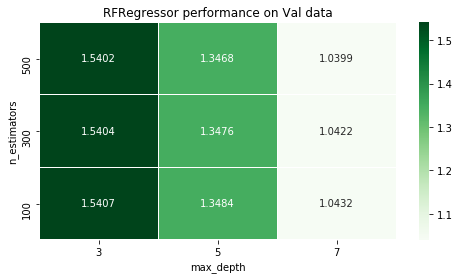

In [174]:
plotModelPerfForBestHyperParam(np.array(val_rmse).reshape(3,3),'Val','RFRegressor')

Observation <br>
max_depth : 7 , n_estimators : 500

In [175]:
#run model with best hyper-parameters
with parallel_backend('dask'):
    best_rf_model = RandomForestRegressor(max_depth=7,n_estimators=500,criterion='mse',random_state=33)
    best_rf_model.fit(dev_X,dev_y)
    dev_preds_rf = best_rf_model.predict(dev_X)
    val_preds_rf = best_rf_model.predict(val_X)
    test_preds_rf = best_rf_model.predict(test_X)

In [176]:
print("Dev RMSLE:",calculateRMSE(dev_preds_rf,'dev'))
print("Val RMSLE:",calculateRMSE(val_preds_rf,'val'))
print("Test RMSLE:",calculateRMSE(test_preds_rf,'test'))

Dev RMSLE: 0.9840826750475115
Val RMSLE: 1.0398658486888384
Test RMSLE: 1.9394285695868172


In [177]:
#generate Submission file for Kaggle
rmsle_rf = generateSubmissionFile('rf',test_preds_rf)

In [178]:
print("Test RMSLE:",rmsle_rf)

Test RMSLE: 1.9394285695868172


<b> kaggle score for RandomForestRegressor </b>
<img src="https://i.imgur.com/bUHMSEK.png"/>

#### Tuning <i>max_depth</i> parameter

In [187]:
devd_rmse = []
vald_rmse = []
for depth in max_depth_tuning:
    rfd_reg = RandomForestRegressor(n_estimators=500,criterion="mse",max_depth=depth,random_state=33) 
    rfd_reg.fit(dev_X,dev_y)

    rfd_pred_dev_y = rfd_reg.predict(dev_X)
    rfd_pred_val_y = rfd_reg.predict(val_X)

    devd_rmse.append(calculateRMSE(rfd_pred_dev_y,'dev'))
    vald_rmse.append(calculateRMSE(rfd_pred_val_y,'val'))

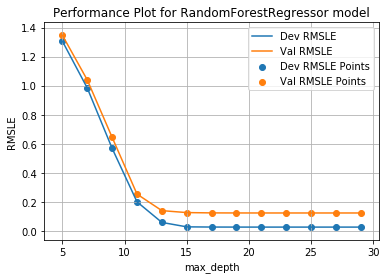

In [188]:
plotModelPerfForBestMaxDepth(devd_rmse,vald_rmse, 'RandomForestRegressor')

Best max_depth:13

In [195]:
#run model with best hyper-parameters
best_rfd_model = RandomForestRegressor(max_depth=13,n_estimators=500,criterion='mse',random_state=33)
best_rfd_model.fit(dev_X,dev_y)
dev_preds_rfd = best_rfd_model.predict(dev_X)
val_preds_rfd = best_rfd_model.predict(val_X)
test_preds_rfd = best_rfd_model.predict(test_X)

In [196]:
print("Dev RMSLE:",calculateRMSE(dev_preds_rfd,'dev'))
print("Val RMSLE:",calculateRMSE(val_preds_rfd,'val'))
print("Test RMSLE:",calculateRMSE(test_preds_rfd,'test'))

Dev RMSLE: 0.060692746834565416
Val RMSLE: 0.1416524788161004
Test RMSLE: 2.055847017075117


In [197]:
#generate Submission file for Kaggle
rmsle_rfd = generateSubmissionFile('rf_depth',test_preds_rfd)
print("Test RMSLE:",rmsle_rfd)

Test RMSLE: 2.055847017075117


<b> kaggle score for RandomForestRegressor tuned max_depth </b>
<img src="https://i.imgur.com/kcc55qF.png"/>

#### Saving the best model

In [179]:
modelfile = 'rf.model'
joblib.dump(best_rf_model,modelfile) #saving model

['rf.model']

In [180]:
#testing saved model
best_rf = joblib.load(modelfile)
test_chk = best_rf.predict(test_X)
print("Test RMSLE:",calculateRMSE(test_chk,'test'))

Test RMSLE: 1.9394285695868172


<h3> Building Neural Networks</h3><a class="anchor" id="nn"></a>

<h4> Building a MultiLayer Neural Network</h4> <a class="anchor" id="mlp_nn"></a>

In [78]:
#Normalizing Numeric Cols
norm = Normalizer()
for ncol in numeric_cols:    
    norm.fit(dev_X[ncol].values.reshape(1,-1))
    dfit_col     = norm.transform(dev_X[ncol].values.reshape(1,-1))
    dev_X[ncol]  = dfit_col.reshape(-1,1)
    vfit_col     = norm.transform(val_X[ncol].values.reshape(1,-1))
    val_X[ncol]  = vfit_col.reshape(-1,1)
    tfit_col     = norm.transform(test_X[ncol].values.reshape(1,-1))
    test_X[ncol] = tfit_col.reshape(-1,1)

del dfit_col, vfit_col, tfit_col

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [146]:
## Saving the normalizer
nn_normalizer = 'mlp_normalizer'
joblib.dump(norm,nn_normalizer)

['mlp_normalizer']

In [79]:
dev_X[numeric_cols].head()

,totals.hits,totals.pageviews,visitNumber,visitStartTime,totals.bounces,totals.newVisits
0,0.000086,0.000119,0.000092,0.000865,0.001207,0.000987
1,0.000172,0.000238,0.000553,0.000865,0.000000,0.000000
2,0.000172,0.000238,0.000092,0.000865,0.000000,0.000987
3,0.000172,0.000238,0.000092,0.000865,0.000000,0.000987
4,0.000172,0.000238,0.000092,0.000865,0.000000,0.000987


In [80]:
model = Sequential()
model.add(Dense(128,kernel_initializer='glorot_normal',input_dim=dev_X.shape[1]))
model.add(Dropout(rate=0.2))
model.add(Dense(64,kernel_initializer='glorot_normal',activation='relu',kernel_regularizer=regularizers.l1(0.001)))
model.add(Dropout(rate=0.2))
model.add(Dense(32,kernel_initializer='glorot_normal',activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(16,kernel_initializer='glorot_normal',activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(rate=0.1))
model.add(Dense(8,kernel_initializer='glorot_normal',activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(1,kernel_initializer='glorot_normal'))
model.compile(loss='mean_squared_logarithmic_error',optimizer='adam')

In [81]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               3840      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0

In [82]:
#https://machinelearningmastery.com/check-point-deep-learning-models-keras/
import time
model_weights = './model_mlp.weights'
model_name = "MLP_{}".format(int(time.time()))
model_checkPt = ModelCheckpoint(model_weights,monitor='val_loss',verbose=1,save_best_only = True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=5,min_lr=1e-07,cooldown=2,verbose=1)
early_stop = EarlyStopping(monitor='val_loss',patience=10)
tnsr_board = TensorBoard(log_dir="./logs/{}".format(model_name))
call_backlist =[model_checkPt,reduce_lr,early_stop,tnsr_board]

In [83]:
model_history = model.fit(x=dev_X.values,y=dev_y,batch_size=256,epochs=100,verbose=1,callbacks=call_backlist,validation_data=(val_X.values,val_y))


Epoch 1/100
5334/5334 [==============================] - ETA: 0s - loss: 0.1373
Epoch 00001: val_loss improved from inf to 0.07097, saving model to ./model_mlp.weights
5334/5334 [==============================] - 20s 4ms/step - loss: 0.1373 - val_loss: 0.0710
Epoch 2/100
5328/5334 [============================>.] - ETA: 0s - loss: 0.0738
Epoch 00002: val_loss improved from 0.07097 to 0.07091, saving model to ./model_mlp.weights
5334/5334 [==============================] - 18s 3ms/step - loss: 0.0738 - val_loss: 0.0709
Epoch 3/100
5330/5334 [============================>.] - ETA: 0s - loss: 0.0738
Epoch 00003: val_loss did not improve from 0.07091
5334/5334 [==============================] - 16s 3ms/step - loss: 0.0738 - val_loss: 0.0709
Epoch 4/100
5320/5334 [============================>.] - ETA: 0s - loss: 0.0738
Epoch 00004: val_loss did not improve from 0.07091
5334/5334 [==============================] - 16s 3ms/step - loss: 0.0738 - val_loss: 0.0709
Epoch 5/100
5328/5334 [=======

In [84]:
def plotLoss(modelName, model):
    """
    Function to plot model rmsle
    """
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch')
    ax.set_ylabel('root_mean_square_log_error')
    ax.set_title(modelName + ' Error plot')
    vy = model.history['val_loss']
    ty = model.history['loss']
    x = list(range(1,len(vy)+1))
    ax.plot(x,vy,'b',label='Val RMSLE')
    ax.plot(x,ty,'r',label='Dev RMSLE')
    plt.legend()
    plt.grid()
    plt.show()

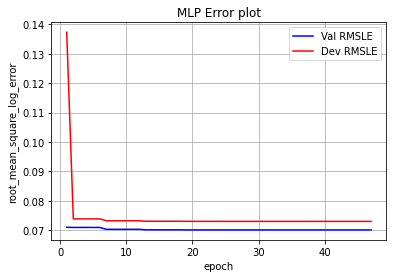

In [85]:
plotLoss('MLP',model_history)

In [86]:
dev_preds_mlp = model.predict(dev_X)
val_preds_mlp = model.predict(val_X)
test_preds_mlp = model.predict(test_X)

In [87]:
print("Dev RMSLE:",calculateRMSE(dev_preds_mlp,'dev'))
print("Val RMSLE:",calculateRMSE(val_preds_mlp,'val'))
print("Test RMSLE:",calculateRMSE(test_preds_mlp,'test'))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


Dev RMSLE: 1.8567233000019765


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


Val RMSLE: 1.8264795121892383


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


Test RMSLE: 2.0574836532339704


In [199]:
#generate Submission file for Kaggle
rmsle_mlp = generateSubmissionFile('mlp',test_preds_mlp)


<b> kaggle score for MLP </b>
<img src="https://i.imgur.com/s4TX4Sx.png"/>

<h4> Applying LSTM</h4> <a class="anchor" id="lstm_nn"></a>

In [88]:
lstm_model = Sequential()
lstm_model.add(LSTM(128,input_shape=(dev_X.shape[1],1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(Flatten())
lstm_model.add(Dense(64,activation='relu',kernel_initializer='glorot_normal',kernel_regularizer=regularizers.l2(0.001)))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(32,activation='tanh',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.0001)))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(16,activation='relu',kernel_initializer='glorot_normal'))
lstm_model.add(Dense(1,kernel_initializer='glorot_normal'))
lstm_model.compile(loss='mean_squared_logarithmic_error',optimizer='adam')

In [89]:
lstm_model_weights = './model_lstm.weights'
lstm_model_name = "LSTM_{}".format(int(time.time()))
lstm_tnsr_board = TensorBoard(log_dir="./logs/LSTM/{}".format(lstm_model_name))
lstm_model_checkPt = ModelCheckpoint(lstm_model_weights,monitor='val_loss',verbose=1,save_best_only = True, mode='min')
lstm_reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=1,min_lr=1e-07,cooldown=2,verbose=1)
lstm_early_stop = EarlyStopping(monitor='val_loss',patience=3)
lstm_call_backlist =[lstm_model_checkPt,lstm_reduce_lr,lstm_early_stop,lstm_tnsr_board]

In [90]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)               

In [91]:
lstm_model_history = lstm_model.fit(x=dev_X.values.reshape(dev_X.shape[0],dev_X.shape[1],1),y=dev_y,batch_size=512,epochs=30,verbose=1,callbacks=lstm_call_backlist,validation_data=(val_X.values.reshape(val_X.shape[0],val_X.shape[1],1),val_y))

Epoch 1/30
2667/2667 [==============================] - ETA: 0s - loss: 0.0730
Epoch 00001: val_loss improved from inf to 0.06685, saving model to ./model_lstm.weights
2667/2667 [==============================] - 334s 125ms/step - loss: 0.0730 - val_loss: 0.0668
Epoch 2/30
2667/2667 [==============================] - ETA: 0s - loss: 0.0687
Epoch 00002: val_loss improved from 0.06685 to 0.06506, saving model to ./model_lstm.weights
2667/2667 [==============================] - 332s 125ms/step - loss: 0.0687 - val_loss: 0.0651
Epoch 3/30
2667/2667 [==============================] - ETA: 0s - loss: 0.0664
Epoch 00003: val_loss improved from 0.06506 to 0.06136, saving model to ./model_lstm.weights
2667/2667 [==============================] - 332s 125ms/step - loss: 0.0664 - val_loss: 0.0614
Epoch 4/30
2667/2667 [==============================] - ETA: 0s - loss: 0.0616
Epoch 00004: val_loss improved from 0.06136 to 0.05673, saving model to ./model_lstm.weights
2667/2667 [====================

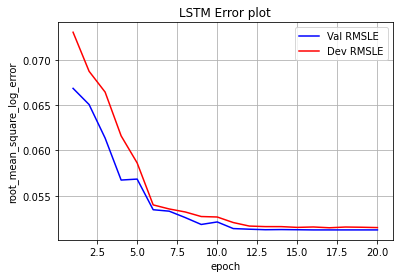

In [92]:
plotLoss('LSTM',lstm_model_history)

In [93]:
dev_preds_lstm = lstm_model.predict(dev_X.values.reshape(dev_X.shape[0],dev_X.shape[1],1))

In [94]:
val_preds_lstm = lstm_model.predict(val_X.values.reshape(val_X.shape[0],val_X.shape[1],1))

In [95]:
test_preds_lstm = lstm_model.predict(test_X.values.reshape(test_X.shape[0],test_X.shape[1],1))

In [96]:
print("Dev RMSLE:",calculateRMSE(dev_preds_lstm,'dev'))
print("Val RMSLE:",calculateRMSE(val_preds_lstm,'val'))
print("Test RMSLE:",calculateRMSE(test_preds_lstm,'test'))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


Dev RMSLE: 1.6357346572083673


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


Val RMSLE: 1.633524744705809


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


Test RMSLE: 2.056983366030572


In [97]:
#generate Submission file for Kaggle
rmsle_lstm = generateSubmissionFile('lstm',test_preds_lstm)
print(rmsle_lstm)

2.056983366030572


<b> kaggle score for LSTM </b>
<img src="https://i.imgur.com/UhxH8nz.png"/>

<h4> Applying Conv1D </h4> <a class="anchor" id="conv_nn"></a>

In [98]:
conv_model = Sequential()
conv_model.add(Conv1D(64,3,input_shape=(dev_X.shape[1],1),activation='relu',kernel_initializer='glorot_normal'))
conv_model.add(Conv1D(32,3,activation='relu',kernel_initializer='glorot_normal'))
conv_model.add(Flatten())
conv_model.add(Dense(64,activation='relu',kernel_initializer='glorot_normal'))
conv_model.add(Dropout(0.25))
conv_model.add(Dense(32,activation='relu',kernel_initializer='glorot_normal'))
conv_model.add(Dropout(0.15))
conv_model.add(Dense(16,activation='relu',kernel_initializer='glorot_normal'))
conv_model.add(Dropout(0.3))
conv_model.add(Dense(1,kernel_initializer='glorot_normal'))
conv_model.compile(loss='mean_squared_logarithmic_error',optimizer='adam')

In [99]:
conv_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 27, 64)            256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 25, 32)            6176      
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                51264     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)               

In [101]:
conv_model_weights = './model_conv1d.weights'
conv_model_name = "CONV1D_{}".format(int(time.time()))
conv_tnsr_board = TensorBoard(log_dir="./logs/{}".format(conv_model_name))
conv_model_checkPt = ModelCheckpoint(conv_model_weights,monitor='val_loss',verbose=1,save_best_only = True, mode='min')
conv_reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=1,min_lr=1e-07,cooldown=2,verbose=1)
conv_early_stop = EarlyStopping(monitor='val_loss',patience=3)
conv_call_backlist =[conv_model_checkPt,conv_reduce_lr,conv_early_stop,conv_tnsr_board]

In [102]:
conv_model_history = conv_model.fit(x=dev_X.values.reshape(dev_X.shape[0],dev_X.shape[1],1),y=dev_y,batch_size=256,epochs=30,verbose=1,callbacks=conv_call_backlist,validation_data=(val_X.values.reshape(val_X.shape[0],val_X.shape[1],1),val_y))

Epoch 1/30
5333/5334 [============================>.] - ETA: 0s - loss: 0.0733
Epoch 00001: val_loss improved from inf to 0.07007, saving model to ./model_conv1d.weights
5334/5334 [==============================] - 49s 9ms/step - loss: 0.0733 - val_loss: 0.0701
Epoch 2/30
5330/5334 [============================>.] - ETA: 0s - loss: 0.0730
Epoch 00002: val_loss did not improve from 0.07007

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
5334/5334 [==============================] - 47s 9ms/step - loss: 0.0730 - val_loss: 0.0701
Epoch 3/30
5332/5334 [============================>.] - ETA: 0s - loss: 0.0730
Epoch 00003: val_loss did not improve from 0.07007
5334/5334 [==============================] - 46s 9ms/step - loss: 0.0730 - val_loss: 0.0701
Epoch 4/30
5329/5334 [============================>.] - ETA: 0s - loss: 0.0730
Epoch 00004: val_loss did not improve from 0.07007

Epoch 00004: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.


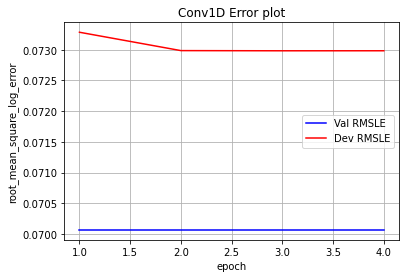

In [103]:
plotLoss('Conv1D',conv_model_history)

In [124]:
dev_preds_conv = conv_model.predict(dev_X.values.reshape(dev_X.shape[0],dev_X.shape[1],1))
val_preds_conv = conv_model.predict(val_X.values.reshape(val_X.shape[0],val_X.shape[1],1))
test_preds_conv = conv_model.predict(test_X.values.reshape(test_X.shape[0],test_X.shape[1],1))

In [125]:
print("Dev RMSLE:",calculateRMSE(dev_preds_conv,'dev'))
print("Val RMSLE:",calculateRMSE(val_preds_conv,'val'))
print("Test RMSLE:",calculateRMSE(test_preds_conv,'test'))

Dev RMSLE: 1.8567233000019765
Val RMSLE: 1.8264795121892383
Test RMSLE: 2.0574836532339704


<b>Observation:</b> <br>
<b> No improvement is observed for this network</b>

###### No improvement observed after applying  Conv1D. We try to add more features and train the networks again

<h4> Adding more features to train our neural networks</h4> <a class="anchor" id="feats"></a>

In [104]:
#https://www.kaggle.com/ashishpatel26/1-43-plb-feature-engineering-best-model-combined
# Building more features
#train data
cust_df["pdate"] = pd.to_datetime(cust_df["date"])
cust_df["day"] = cust_df["pdate"].dt.day
cust_df["weekday"] = cust_df["pdate"].dt.weekday
cust_df["month"] = cust_df["pdate"].dt.month
cust_df["weekofyear"] = cust_df["pdate"].dt.weekofyear
cust_df["day_unique_user_count"] = cust_df.groupby('day')['fullVisitorId'].transform('nunique')
cust_df["week_unique_user_count"] = cust_df.groupby('weekday')['fullVisitorId'].transform('nunique')
cust_df["month_unique_user_count"] = cust_df.groupby('month')['fullVisitorId'].transform('nunique')
cust_df["day_mean_hits"] = cust_df.groupby('day')['totals.hits'].transform('mean')
cust_df["day_max_hits"] = cust_df.groupby('day')['totals.hits'].transform('max')
cust_df["day_min_hits"] = cust_df.groupby('day')['totals.hits'].transform('min')
cust_df["day_mean_views"] = cust_df.groupby('day')['totals.pageviews'].transform('mean')
cust_df["day_max_views"] = cust_df.groupby('day')['totals.pageviews'].transform('max')
cust_df["day_min_views"] = cust_df.groupby('day')['totals.pageviews'].transform('min')

#test data
test_df["pdate"] = pd.to_datetime(test_df["date"])
test_df["day"] = test_df["pdate"].dt.day
test_df["weekday"] = test_df["pdate"].dt.weekday
test_df["month"] = test_df["pdate"].dt.month
test_df["weekofyear"] = test_df["pdate"].dt.weekofyear
test_df["day_unique_user_count"] = test_df.groupby('day')['fullVisitorId'].transform('nunique')
test_df["week_unique_user_count"] = test_df.groupby('weekday')['fullVisitorId'].transform('nunique')
test_df["month_unique_user_count"] = test_df.groupby('month')['fullVisitorId'].transform('nunique')
test_df["day_mean_hits"] = test_df.groupby('day')['totals.hits'].transform('mean')
test_df["day_max_hits"] = test_df.groupby('day')['totals.hits'].transform('max')
test_df["day_min_hits"] = test_df.groupby('day')['totals.hits'].transform('min')
test_df["day_mean_views"] = test_df.groupby('day')['totals.pageviews'].transform('mean')
test_df["day_max_views"] = test_df.groupby('day')['totals.pageviews'].transform('max')
test_df["day_min_views"] = test_df.groupby('day')['totals.pageviews'].transform('min')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


In [105]:
test_df.head(3)

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.timeOnSite,totals.sessionQualityDim,totals.newVisits,totals.transactions,totals.transactionRevenue,totals.bounces,trafficSource.referralPath,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adContent,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,PredRevenue,pdate,day,weekday,month,weekofyear,day_unique_user_count,week_unique_user_count,month_unique_user_count,day_mean_hits,day_max_hits,day_min_hits,day_mean_views,day_max_views,day_min_views
0,0,2018-05-11,7460955084541987166,1526099341,2.0,1.526099e+09,1,2,True,1,2,5,9,26,3,5,2,4.0,3.0,973,1,0.0,NaN,0.0,0.0,-1,0,0,0,2,-1,0,-1,-1,-1,-1,-1,0.0,2018-05-11,11,4,5,19,13696,49085,68494,4.324427,87.0,1.0,3.496523,67.0,0.0
1,2,2018-05-11,460252456180441002,1526064483,166.0,1.526064e+09,1,3,False,0,1,1,1,1,1,2,0,4.0,3.0,49,1,0.0,NaN,0.0,0.0,-1,0,2,2,-1,-1,0,-1,-1,-1,-1,-1,0.0,2018-05-11,11,4,5,19,13696,49085,68494,4.324427,87.0,1.0,3.496523,67.0,0.0
2,0,2018-05-11,3461808543879602873,1526067157,2.0,1.526067e+09,1,1,False,0,1,1,1,0,0,0,-1,4.0,3.0,24,1,0.0,NaN,0.0,0.0,-1,0,0,0,2,-1,0,-1,-1,-1,-1,-1,0.0,2018-05-11,11,4,5,19,13696,49085,68494,4.324427,87.0,1.0,3.496523,67.0,0.0


In [106]:
special_features = ['day','weekday','month','weekofyear','day_unique_user_count','week_unique_user_count','month_unique_user_count',
                    'day_mean_hits','day_max_hits','day_min_hits','day_mean_views','day_max_views','day_min_views']


In [107]:
# Split the train dataset into development and valid based on time 
devF_df = cust_df[cust_df['date']<=datetime.date(2017,12,31)]
valF_df = cust_df[cust_df['date']>datetime.date(2017,12,31)]


devF_X = devF_df[catgry_cols+numeric_cols+special_features]
devF_y = np.log1p(devF_df['totals.transactionRevenue']) 
valF_X = valF_df[catgry_cols+numeric_cols+special_features] 
valF_y = np.log1p(valF_df['totals.transactionRevenue']) 
testF_X = test_df[catgry_cols+numeric_cols+special_features]

In [108]:
spec_norm = Normalizer()
for ncol in special_features:
    spec_norm.fit(devF_X[ncol].values.reshape(1,-1))
    dfit_col     = spec_norm.transform(devF_X[ncol].values.reshape(1,-1))
    devF_X[ncol]  = dfit_col.reshape(-1,1)
    vfit_col     = spec_norm.transform(valF_X[ncol].values.reshape(1,-1))
    valF_X[ncol]  = vfit_col.reshape(-1,1)
    tfit_col     = spec_norm.transform(testF_X[ncol].values.reshape(1,-1))
    testF_X[ncol] = tfit_col.reshape(-1,1)

del dfit_col, vfit_col, tfit_col

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

#### Applying MLP with more features in dataset

In [109]:
modelF = Sequential()
modelF.add(Dense(128,kernel_initializer='glorot_normal',input_dim=devF_X.shape[1]))
modelF.add(Dropout(rate=0.3))
modelF.add(Dense(64,kernel_initializer='glorot_normal',activation='relu',kernel_regularizer=regularizers.l1(0.01)))
modelF.add(Dropout(rate=0.15))
modelF.add(Dense(32,kernel_initializer='glorot_normal',activation='relu',kernel_regularizer=regularizers.l2(0.001)))
modelF.add(Dense(16,kernel_initializer='glorot_normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
modelF.add(Dropout(rate=0.25))
modelF.add(Dense(8,kernel_initializer='glorot_normal',activation='relu',kernel_regularizer=regularizers.l2(0.001)))
modelF.add(Dense(1,kernel_initializer='glorot_normal'))
modelF.compile(loss='mean_squared_logarithmic_error',optimizer='adam')


In [110]:
modelF_weights = './modelF_mlp.weights'
mlpf_model_name = "MLPF_{}".format(int(time.time()))
mlpf_tnsr_board = TensorBoard(log_dir="./logs/{}".format(mlpf_model_name))
modelF_checkPt = ModelCheckpoint(modelF_weights,monitor='val_loss',verbose=1,save_best_only = True, mode='min')
reduce_lrF = ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=5,min_lr=1e-07,cooldown=2,verbose=1)
early_stopF = EarlyStopping(monitor='val_loss',patience=10)
call_backlistF =[modelF_checkPt,reduce_lrF,early_stopF,mlpf_tnsr_board]

In [111]:
model_historyF = modelF.fit(x=devF_X.values,y=devF_y,batch_size=256,epochs=100,verbose=1,callbacks=call_backlistF,validation_data=(valF_X.values,valF_y))

Epoch 1/100
5318/5334 [============================>.] - ETA: 0s - loss: 2.9582
Epoch 00001: val_loss improved from inf to 0.58238, saving model to ./modelF_mlp.weights
5334/5334 [==============================] - 19s 3ms/step - loss: 2.9516 - val_loss: 0.5824
Epoch 2/100
5321/5334 [============================>.] - ETA: 0s - loss: 0.4452
Epoch 00002: val_loss improved from 0.58238 to 0.12227, saving model to ./modelF_mlp.weights
5334/5334 [==============================] - 19s 3ms/step - loss: 0.4445 - val_loss: 0.1223
Epoch 3/100
5317/5334 [============================>.] - ETA: 0s - loss: 0.1902
Epoch 00003: val_loss improved from 0.12227 to 0.08785, saving model to ./modelF_mlp.weights
5334/5334 [==============================] - 18s 3ms/step - loss: 0.1899 - val_loss: 0.0879
Epoch 4/100
5320/5334 [============================>.] - ETA: 0s - loss: 0.1222
Epoch 00004: val_loss improved from 0.08785 to 0.08023, saving model to ./modelF_mlp.weights
5334/5334 [=========================

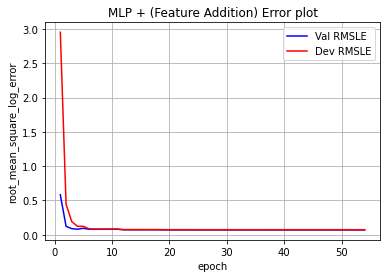

In [112]:
plotLoss('MLP + (Feature Addition)',model_historyF)

In [113]:
dev_predsF = modelF.predict(devF_X.values)

In [114]:
val_predsF = modelF.predict(valF_X.values)

In [115]:
test_predsF = modelF.predict(testF_X.values)

In [116]:
print("Dev RMSLE:",calculateRMSE(dev_predsF,'dev'))
print("Val RMSLE:",calculateRMSE(val_predsF,'val'))
print("Test RMSLE:",calculateRMSE(test_predsF,'test'))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


Dev RMSLE: 1.8567233000019765


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


Val RMSLE: 1.8264795121892383


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


Test RMSLE: 2.0574836532339704


In [160]:
#generate Submission file for Kaggle
rmsle_mlpF = generateSubmissionFile('mlp_featured',test_predsF)
print(rmsle_mlpF)

2.0574836532339704


<b> kaggle score for MLP Featured </b>
<img src="https://i.imgur.com/8JeumPi.png"/>


#### Applying LSTM with more features in dataset

In [117]:
lstm_modelF = Sequential()
lstm_modelF.add(LSTM(100,input_shape=(devF_X.shape[1],1)))
lstm_modelF.add(Dropout(0.3))
lstm_modelF.add(Flatten())
lstm_modelF.add(Dense(64,activation='relu',kernel_initializer='glorot_normal'))
lstm_modelF.add(Dropout(0.25))
lstm_modelF.add(Dense(32,activation='relu',kernel_initializer='glorot_normal'))
lstm_modelF.add(Dropout(0.2))
lstm_modelF.add(Dense(16,activation='relu',kernel_initializer='glorot_normal'))
lstm_modelF.add(Dense(1,kernel_initializer='glorot_normal'))
lstm_modelF.compile(loss='mean_squared_logarithmic_error',optimizer='adam')

In [118]:
lstm_modelF_weights = './modelF_lstm.weights'
lstm_modelF_name = "LSTMF_{}".format(int(time.time()))
lstm_tnsr_boardF = TensorBoard(log_dir="./logs/{}".format(lstm_modelF_name))
lstm_modelF_checkPt = ModelCheckpoint(lstm_modelF_weights,monitor='val_loss',verbose=1,save_best_only = True, mode='min')
lstm_reduce_lrF = ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=1,min_lr=1e-07,cooldown=2,verbose=1)
lstm_early_stopF = EarlyStopping(monitor='val_loss',patience=3)
lstm_call_backlistF =[lstm_modelF_checkPt,lstm_reduce_lrF,lstm_early_stopF,lstm_tnsr_boardF]

In [119]:
lstm_modelF_history = lstm_modelF.fit(x=devF_X.values.reshape(devF_X.shape[0],devF_X.shape[1],1),y=dev_y,batch_size=256,epochs=30,verbose=1,callbacks=lstm_call_backlistF,validation_data=(valF_X.values.reshape(valF_X.shape[0],valF_X.shape[1],1),val_y))

Epoch 1/30
5333/5334 [============================>.] - ETA: 0s - loss: 0.0480
Epoch 00001: val_loss improved from inf to 0.04985, saving model to ./modelF_lstm.weights
5334/5334 [==============================] - 497s 93ms/step - loss: 0.0480 - val_loss: 0.0499
Epoch 2/30
5333/5334 [============================>.] - ETA: 0s - loss: 0.0253
Epoch 00002: val_loss improved from 0.04985 to 0.02105, saving model to ./modelF_lstm.weights
5334/5334 [==============================] - 484s 91ms/step - loss: 0.0253 - val_loss: 0.0210
Epoch 3/30
5333/5334 [============================>.] - ETA: 0s - loss: 0.0194
Epoch 00003: val_loss did not improve from 0.02105

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
5334/5334 [==============================] - 489s 92ms/step - loss: 0.0194 - val_loss: 0.0262
Epoch 4/30
5333/5334 [============================>.] - ETA: 0s - loss: 0.0156
Epoch 00004: val_loss improved from 0.02105 to 0.01659, saving model to ./modelF_lstm

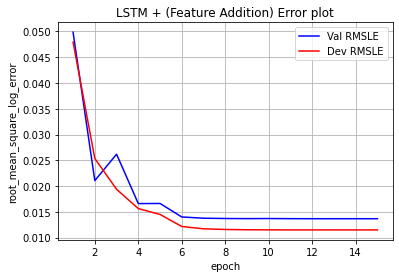

In [120]:
plotLoss('LSTM + (Feature Addition)',lstm_modelF_history)

In [121]:
dev_preds_lstmF = lstm_modelF.predict(devF_X.values.reshape(devF_X.shape[0],devF_X.shape[1],1))

In [122]:
val_preds_lstmF = lstm_modelF.predict(valF_X.values.reshape(valF_X.shape[0],valF_X.shape[1],1))

In [123]:
test_preds_lstmF = lstm_modelF.predict(testF_X.values.reshape(testF_X.shape[0],testF_X.shape[1],1))

In [124]:
print("Dev RMSLE:",calculateRMSE(dev_preds_lstmF,'dev'))
print("Val RMSLE:",calculateRMSE(val_preds_lstmF,'val'))
print("Test RMSLE:",calculateRMSE(test_preds_lstmF,'test'))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


Dev RMSLE: 0.81130131466539


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


Val RMSLE: 0.8719806838654006


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


Test RMSLE: 2.042451120185074


In [125]:
#generate Submission file for Kaggle
rmsle_lstmF = generateSubmissionFile('lstm_featured',test_preds_lstmF)
print(rmsle_lstmF)

2.042451120185074


<b> kaggle score for LSTM Featured </b>
<img src="https://i.imgur.com/wJUZdB0.png"/>


#### Applying Conv1D with more features in dataset

In [126]:
conv_modelF = Sequential()
conv_modelF.add(Conv1D(64,3,input_shape=(devF_X.shape[1],1),activation='relu',kernel_initializer='glorot_normal'))
conv_modelF.add(Dropout(0.25))
conv_modelF.add(Conv1D(32,2,activation='relu',kernel_initializer='glorot_normal'))
conv_modelF.add(Flatten())
conv_modelF.add(Dense(64,activation='relu',kernel_initializer='glorot_normal'))
conv_modelF.add(Dropout(0.25))
conv_modelF.add(Dense(32,activation='relu',kernel_initializer='glorot_normal',kernel_regularizer=regularizers.l2(0.001)))
conv_modelF.add(Dropout(0.15))
conv_modelF.add(Dense(16,activation='relu',kernel_initializer='glorot_normal'))
conv_modelF.add(Dropout(0.2))
conv_modelF.add(Dense(1,kernel_initializer='glorot_normal'))
conv_modelF.compile(loss='mean_squared_logarithmic_error',optimizer='adam')

In [127]:
conv_modelF_weights = './modelF_conv1d.weights'
conv_modelF_name = "CONV1DF_{}".format(int(time.time()))
conv_tnsr_boardF = TensorBoard(log_dir="./logs/{}".format(conv_modelF_name))
conv_modelF_checkPt = ModelCheckpoint(conv_modelF_weights,monitor='val_loss',verbose=1,save_best_only = True, mode='min')
conv_reduce_lrF = ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=1,min_lr=1e-07,cooldown=2,verbose=1)
conv_early_stopF = EarlyStopping(monitor='val_loss',patience=3)
conv_call_backlistF =[conv_modelF_checkPt,conv_reduce_lrF,conv_early_stopF,conv_tnsr_boardF]

In [128]:
conv_modelF_history = conv_modelF.fit(x=devF_X.values.reshape(devF_X.shape[0],devF_X.shape[1],1),y=dev_y,batch_size=256,epochs=30,verbose=1,callbacks=conv_call_backlistF,validation_data=(valF_X.values.reshape(valF_X.shape[0],valF_X.shape[1],1),val_y))

Epoch 1/30
5332/5334 [============================>.] - ETA: 0s - loss: 0.1272
Epoch 00001: val_loss improved from inf to 0.08441, saving model to ./modelF_conv1d.weights
5334/5334 [==============================] - 82s 15ms/step - loss: 0.1272 - val_loss: 0.0844
Epoch 2/30
5333/5334 [============================>.] - ETA: 0s - loss: 0.0810
Epoch 00002: val_loss improved from 0.08441 to 0.07271, saving model to ./modelF_conv1d.weights
5334/5334 [==============================] - 82s 15ms/step - loss: 0.0810 - val_loss: 0.0727
Epoch 3/30
5333/5334 [============================>.] - ETA: 0s - loss: 0.0740
Epoch 00003: val_loss improved from 0.07271 to 0.07028, saving model to ./modelF_conv1d.weights
5334/5334 [==============================] - 81s 15ms/step - loss: 0.0740 - val_loss: 0.0703
Epoch 4/30
5333/5334 [============================>.] - ETA: 0s - loss: 0.0735
Epoch 00004: val_loss improved from 0.07028 to 0.07015, saving model to ./modelF_conv1d.weights
5334/5334 [==============

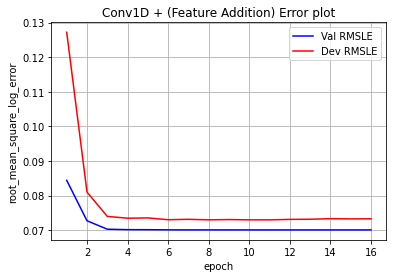

In [129]:
plotLoss('Conv1D + (Feature Addition)',conv_modelF_history)

In [130]:
dev_preds_convF = conv_modelF.predict(devF_X.values.reshape(devF_X.shape[0],devF_X.shape[1],1))

In [131]:
val_preds_convF = conv_modelF.predict(valF_X.values.reshape(valF_X.shape[0],valF_X.shape[1],1))

In [132]:
test_preds_convF = conv_modelF.predict(testF_X.values.reshape(testF_X.shape[0],testF_X.shape[1],1))

In [133]:
print("Dev RMSLE:",calculateRMSE(dev_preds_convF,'dev'))
print("Val RMSLE:",calculateRMSE(val_preds_convF,'val'))
print("Test RMSLE:",calculateRMSE(test_preds_convF,'test'))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


Dev RMSLE: 1.8567233000019765


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


Val RMSLE: 1.8264795121892383


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


Test RMSLE: 2.0574836532339704


<b>Observation:</b> <br>
<b> No improvement is observed for this network</b>

<h2>Analysis of various Model Implementations</h2> <a class="anchor" id="analyze"></a>

<h3> Data Loading and Preprocessing</h3> <a class="anchor" id="preprocess"></a>
<ul>
    <li> As the dataset size is beyond the capacity of RAM, Have used dask for loading and processing of data </li>
    <li> Converted the json fields into normal columns </li>
    <li> Handled data type changes </li>
    <li> Removed redundant columns and also columns with single value </li>
    <li> Handled missing values,for numeric columns used mean replacement </li>
    <li> Analyzed various features using plots </li>
</ul>

<h3> Modeling</h3> <a class="anchor" id="model_analysis"></a>

#### Base Models
<ul>
        <li>Started with basic models like LinearRegression and Ridge</li>
        <li> These models have performed well and gave low RMSLE Error</li>
     </ul>

In [107]:
baseGrid = PrettyTable()
baseGrid.field_names = ['Algo','train RMSLE','test RMSLE','normalize','alpha','Private Score']
baseGrid.add_row(['LinearRegression',1.67105,1.86431,False, '******',1.10144])
baseGrid.add_row(['Ridge',1.67288,1.86977,True,0.01,1.04765])
print(baseGrid)

+------------------+-------------+------------+-----------+--------+---------------+
|       Algo       | train RMSLE | test RMSLE | normalize | alpha  | Private Score |
+------------------+-------------+------------+-----------+--------+---------------+
| LinearRegression |   1.67105   |  1.86431   |   False   | ****** |    1.10144    |
|      Ridge       |   1.67288   |  1.86977   |    True   |  0.01  |    1.04765    |
+------------------+-------------+------------+-----------+--------+---------------+


#### Tree based Models
<ul>
    <li>Applied treebased models like XGBRegressor, LGBMRegressor, and RandomForestRegressor on the dataset</li>
        <li> Performed hyperparameter tuning for all the models</li>
        <li> LGBMRegressor is faster in terms of run time performance where as RandomForestRegressor is the slowest </li> 
        <li> In terms of predictions, LGBMRegressor performed well when compared to other tree based models </li>
        <li> XGBRegressor and RandomForestRegressor performance on predictions is almost similar</li>
        <li> XGBRegressor performed well on training data, but lost to other models in terms of performance on test data</li>
        </ul>

In [116]:
treeGrid = PrettyTable()
treeGrid.field_names = ['Regressor','max_depth','n_estimators','learning_rate','devRMSLE','valRMSLE','testRMSLE','PrivateScore']
treeGrid.add_row(['XGB',6,100,0.3,1.15775,1.20059,1.88343,1.22875])
treeGrid.add_row(['XGB',7,300,0.1,0.06581,0.07990,1.91672,1.45883]) 
treeGrid.add_row(['XGB',9,300,0.1,0.04179,0.07205,2.04194,1.51454]) #tuned max_depth

treeGrid.add_row(['LGBM',-1,100,0.1,0.21052,0.25393,2.03758,1.45426])
treeGrid.add_row(['LGBM',15,1500,0.1,0.05236,0.06691,2.01028,1.49459])
treeGrid.add_row(['LGBM',15,1500,0.001,0.91117,0.96845,1.92743,1.15523])
treeGrid.add_row(['LGBM',15,300,0.001,1.52779,1.53022,1.97326,0.94067])

treeGrid.add_row(['RF',7,500,'*****',0.98408,1.03986,1.93942,1.45174])
treeGrid.add_row(['RF',13,500,'*****',0.06069,0.14165,2.05584,1.57448])
print(treeGrid)


+-----------+-----------+--------------+---------------+----------+----------+-----------+--------------+
| Regressor | max_depth | n_estimators | learning_rate | devRMSLE | valRMSLE | testRMSLE | PrivateScore |
+-----------+-----------+--------------+---------------+----------+----------+-----------+--------------+
|    XGB    |     6     |     100      |      0.3      | 1.15775  | 1.20059  |  1.88343  |   1.22875    |
|    XGB    |     7     |     300      |      0.1      | 0.06581  |  0.0799  |  1.91672  |   1.45883    |
|    XGB    |     9     |     300      |      0.1      | 0.04179  | 0.07205  |  2.04194  |   1.51454    |
|    LGBM   |     -1    |     100      |      0.1      | 0.21052  | 0.25393  |  2.03758  |   1.45426    |
|    LGBM   |     15    |     1500     |      0.1      | 0.05236  | 0.06691  |  2.01028  |   1.49459    |
|    LGBM   |     15    |     1500     |     0.001     | 0.91117  | 0.96845  |  1.92743  |   1.15523    |
|    LGBM   |     15    |     300      |     0

#### Neural Networks
<ul><li> Implemented different network architectures</li>
        <li> Developed models like multi layer neural network, LSTM, Conv1D </li>
        <li> Neural networks performed well overall, with better predictions </li>
        <li> Added more features and tested the networks to further improve the performaance models </li>
        </ul>

In [16]:
nnGrid = PrettyTable()
nnGrid.field_names = ['Algo','dev RMSLE','val RMSLE','test RMSLE','Private Score']
nnGrid.add_row(['Neural Network',1.8567,1.8264,2.0574,0.88843])
nnGrid.add_row(['Neural Network + featured',1.8364,1.8078,2.0311,0.91369])
nnGrid.add_row(['LSTM + featured',0.5137,0.6110,2.2896,1.80431])
print(nnGrid)

+---------------------------+-----------+-----------+------------+---------------+
|            Algo           | dev RMSLE | val RMSLE | test RMSLE | Private Score |
+---------------------------+-----------+-----------+------------+---------------+
|       Neural Network      |   1.8567  |   1.8264  |   2.0574   |    0.88843    |
| Neural Network + featured |   1.8364  |   1.8078  |   2.0311   |    0.91369    |
|      LSTM + featured      |   0.5137  |   0.611   |   2.2896   |    1.80431    |
+---------------------------+-----------+-----------+------------+---------------+


<h3>Conclusion</h3> <a class="anchor" id="conclude"></a>
<ul>
    <li> Dask is very handy in processing large datasets with more than the size of typical main memory. This problem statement opened doors for many learning opportunities like processing large datasets using dask, learning from kaggle competitions, applying various machine learning and deep learning models to solve the problem at hand.</li>
    <li> The learnings from this case study can be further propagated to any regression problem  and most importantly gave enough confidence to tackle a kaggle competition</li>
  
</ul>

<h2>Best Score Achieved by Neural Network (0.88843)</h2> <a class="anchor" id="best"></a>